This notebook involves the code for training standard one class classification models.
The main steps followed are:\
1) Feature engineering\
2) Hyperparameter optimization\
3) k-fold cross validation\
4) Visualization of the predictions



# Importing the datasets and libraries

In [ ]:
#Install the pyod library
!git clone https://github.com/yzhao062/pyod.git
%cd pyod
!pip install .

# Install the RDKit library
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

# Append rdkit path to current python system path
%matplotlib inline
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [4]:
# Import the main libraries
from sklearn import datasets, metrics
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
import sys
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial.distance import squareform
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import KFold
from sklearn import preprocessing
from numpy import percentile
import warnings
from sklearn.preprocessing import MinMaxScaler
warnings.simplefilter("ignore", UserWarning)
import seaborn as sns
from random import Random

# import rdkit libraries
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole


# Import all models
from pyod.models.cblof import CBLOF
from pyod.models.abod import ABOD
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.pca import PCA
from pyod.models.cblof import CBLOF
from sklearn.mixture import GaussianMixture


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
# Import the labeled dataset
dataset1 = pd.read_csv('/content/drive/My Drive/cocrystal_design-master/data/coformers1.csv')
dataset2 = pd.read_csv('/content/drive/My Drive/cocrystal_design-master/data/coformers2.csv')
dataset1.head()

Identifier  ... Infective-50
0     WOVMEB  ...          0.0
1     PIWKEL  ...          1.0
2     OTIHIJ  ...          0.0
3     DABLOJ  ...          0.0
4     PIGJUK  ...          0.0

[5 rows x 1859 columns]

In [7]:
# Remove temporary the toluene/benzene solvents for selecting important feature without any possible bias generated by them 
out1 = np.append(dataset2.Identifier[dataset2.NAME == 'Cc1ccccc1'].values, dataset2.Identifier[dataset2.NAME == 'c1ccccc1'].values, axis=0)
out=np.append(out1, dataset2.Identifier[dataset2.NAME == 'Cc1ccc(C)cc1'].values , axis=0)
dataset1= dataset1[~dataset1['Identifier'].isin(out)]
dataset2 = dataset2[~dataset2['Identifier'].isin(out)]

In [8]:
# The two datasets are concateanted for identifing the highly correlated descriptors and remove them
df1_w=dataset1.iloc[:,2:]
df2_w=dataset2.iloc[:,2:]
data = pd.concat([df1_w, df2_w])
data_ = data.drop_duplicates(keep='first')

# Drop the highly linearly correlated features among the datasets
# Create correlation matrix
corr_matrix1 = data_.corr().abs()

# Select upper triangle of correlation matrix
upper1 = corr_matrix1.where(np.triu(np.ones(corr_matrix1.shape), k=1).astype(np.bool))

# Find index of feature columns with Pearson correlation greater than 0.92
to_drop1 = [column for column in upper1.columns if any(upper1[column] > 0.92)]

# Drop the descriptos will low variance, below 0.4
drop = data_.std()[data_.std() < 0.4].index.values
to_drop2= [x for x in drop if x not in to_drop1]
drop_final= to_drop1 + to_drop2

# Remove the selected features from the datasets
df1=df1_w.drop(columns=drop_final)
df1=df1.fillna(df1.mean())
df2=df2_w.drop(columns=drop_final)
df2=df2.fillna(df2.mean())


In [9]:
# Calculate the Spearman correlations of the datasets
cor = df1.corrwith(df2, axis=0, drop=False, method='spearman').abs()
corr=cor.sort_values(ascending=False)

In [10]:
# Construct a vector w which is used to keep only the descriptors that are correlated higher than 0.30 using Spearman correlation
# In this vector, 1 is on the positions of the descriptors that have correlation coeficcient > 0.3,  and 0 otherwise
w = np.array(cor)
np.nan_to_num(w,0)
w[w<0.4] =0
w[w=='NaN']=0
w[w>=0.4] =1

# Multiply the two datasets with the vector w, such that the descriptors with lower correlation will become zero and removed 
df1 = df1*w
df2 = df2*w

df1_1 = df1.loc[:, (df1 != 0).any(axis=0)]
df2_2 = df2.loc[:, (df2 != 0).any(axis=0)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


In [11]:
# Calculate the Pearson correlations of the datasets 
cort= df1_1.corrwith(df2_2, axis=0, drop=False, method='pearson').abs()
corrt=cort.sort_values(ascending=False)

In [12]:
# Keep only descriptors with Pearson correlations > 0.2
w = np.array(cort)
np.nan_to_num(w,0)
w[w<0.4]=0
w[w>=0.4]=1
df1_1 = df1_1*w
df2_2 = df2_2*w
df1_1 = df1_1.loc[:, (df1_1 != 0).any(axis=0)]
df2_2 = df2_2.loc[:, (df2_2 != 0).any(axis=0)]

In [13]:
# Print out the p-value
from scipy.stats.stats import spearmanr
from scipy.stats.stats import pearsonr

for i in df1_1.columns.values:
  print("Descriptor:%s"% i + " " + 'Correlation:%2f' %  pearsonr(df1_1[i].values, df2_2[i].values)[0] + "  " + "p-value:%2f" %  pearsonr(df1_1[i].values, df2_2[i].values)[1])

Descriptor:nBM Correlation:-0.404334  p-value:0.000000
Descriptor:nHet Correlation:-0.519682  p-value:0.000000
Descriptor:ZM1V Correlation:-0.528533  p-value:0.000000
Descriptor:DBI Correlation:-0.548873  p-value:0.000000
Descriptor:MAXDN Correlation:-0.546764  p-value:0.000000
Descriptor:MAXDP Correlation:-0.613201  p-value:0.000000
Descriptor:DELS Correlation:-0.405218  p-value:0.000000
Descriptor:CIC0 Correlation:-0.406025  p-value:0.000000
Descriptor:J_D/Dt Correlation:-0.424448  p-value:0.000000
Descriptor:SM1_Dz(Z) Correlation:-0.561529  p-value:0.000000
Descriptor:SM1_Dz(e) Correlation:-0.492544  p-value:0.000000
Descriptor:HyWi_B(s) Correlation:-0.735810  p-value:0.000000
Descriptor:SpMax4_Bh(m) Correlation:-0.509435  p-value:0.000000
Descriptor:SpMax5_Bh(m) Correlation:-0.632145  p-value:0.000000
Descriptor:SpMax3_Bh(s) Correlation:-0.411440  p-value:0.000000
Descriptor:SpMax7_Bh(s) Correlation:-0.423908  p-value:0.000000
Descriptor:P_VSA_v_2 Correlation:-0.493104  p-value:0.0

In [805]:
# Import the whole dataset and keep only the selected descriptors from the feature engineering part
dataset1 = pd.read_csv('/content/drive/My Drive/cocrystal_design-master/data/coformers1.csv')
dataset2 = pd.read_csv('/content/drive/My Drive/cocrystal_design-master/data/coformers2.csv')
df1 = dataset1.iloc[:, 2:] 
df2 = dataset2.iloc[:, 2:] 
df1 = dataset1[df1_1.columns.values[:]]
df2 = dataset2[df1_1.columns.values[:]]

In [806]:
# Construct the labelled dataset by contatenating the feature set of each coformer in both orders
# We have a vector of 50 dimensions now
def concat_bidirectional(dataset1, dataset2):

  return pd.concat([pd.concat([dataset1['Identifier'], dataset1, dataset2], axis=1), pd.concat([dataset1['Identifier'].apply(lambda x: f"{x}_"),dataset2, dataset1], axis=1) ], axis=0)


In [807]:
# Standarize the dataset
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler()

df_concat = pd.concat([df1, df2])
print(df_concat.shape)
df_concat = df_concat.drop_duplicates(keep='first')
print(df_concat.shape)
numerical_cols = df_concat.columns[:]
df_scaled = pd.DataFrame(X_scaler.fit(df_concat), columns=numerical_cols, index=df_concat.index)


numerical_cols = df2.columns[:]
df1_scaled =  pd.DataFrame(X_scaler.transform(df1[numerical_cols]), columns=numerical_cols, index=df1.index)
df2_scaled = pd.DataFrame(X_scaler.transform(df2[numerical_cols]), columns=numerical_cols, index=df2.index)
df =pd.concat([pd.concat([dataset1['Identifier'], df1_scaled, df2_scaled], axis=1), pd.concat([dataset1['Identifier'].apply(lambda x: f"{x}_"),df2_scaled, df1_scaled], axis=1) ], axis=0)
df


(3444, 24)
(1566, 24)


Identifier       nBM      nHet  ...  Eig04_AEA(dm)     nHAcc        Uc
0        WOVMEB  0.034483  0.000000  ...       0.667916  0.000000  0.796001
1        PIWKEL  0.057471  0.088889  ...       0.668781  0.000000  0.268420
2        OTIHIJ  0.195402  0.044444  ...       0.010378  0.000000  0.376728
3        DABLOJ  0.005747  0.044444  ...       0.715624  0.131579  0.607167
4        PIGJUK  0.074713  0.088889  ...       0.712165  0.105263  0.464233
...         ...       ...       ...  ...            ...       ...       ...
1717    AFOTIB_  0.034483  0.000000  ...       0.642404  0.236842  0.830761
1718    CIQNIC_  0.034483  0.000000  ...       0.708273  0.000000  0.000000
1719    DIVZUG_  0.034483  0.000000  ...       0.628711  0.421053  0.850892
1720    PIQTOB_  0.034483  0.000000  ...       0.424762  0.000000  0.496578
1721    RAWXEU_  0.034483  0.022222  ...       0.569472  0.157895  0.623272

[3444 rows x 49 columns]

In [17]:
# Save the dataset
##df.to_pickle('/content/drive/My Drive/cocrystal_design-master/data_test/df_reduced.pkl')

In [795]:
# Generate the unknown dataset (unlabelled)
# Import the unlabeled data

# Read the Zinc dataset of purcasable molecules with their dragon descriptors
unlabeled = pd.read_csv('/content/drive/My Drive/cocrystal_design-master/data_test/unlabelled_dragon (5).csv')  
val = unlabeled['NAME'].values
length = len(val)
print(length)
unlabeled=unlabeled.loc[:, (unlabeled != 0).any(axis=0)]


pairs = [[val[i],val[j]] for i in range(length) for j in range(length) if i!=j ]

# Remove the duplicate structures
no_dups = []
for pair in pairs:
  if not any(all(i in p for i in pair) for p in no_dups):
    no_dups.append(pair)

pairs = pd.DataFrame(no_dups)
keys = unlabeled['NAME'].values
values = unlabeled.iloc[:, 1:].values

d = {key:value for key, value in zip(keys, values)}


209


In [796]:
mol1_data= list()

for mol1 in pairs[0]:       
    mol1_data.append(d[mol1])
    
mol1_data = pd.DataFrame(mol1_data, columns = unlabeled.iloc[:, 1:].columns.values)   

mol2_data= list()

for mol2 in pairs[1]:   
    mol2_data.append(d[mol2])
mol2_data = pd.DataFrame(mol2_data, columns= unlabeled.iloc[:, 1:].columns.values) 

In [797]:
final_1 = pd.concat([pairs[0],mol1_data],axis=1)
final_1 = final_1.fillna(0)
final_2 = pd.concat([pairs[1],mol2_data],axis=1)
final_2 = final_2.fillna(0)

unlab=pd.concat([pairs[0], pairs[1]], axis=1)
final_1 = final_1.replace({'#NUM!': 0})
final_2 = final_2.replace({'#NUM!': 0})

final_11=final_1[df1.iloc[:,:].columns.values]
final_22=final_2[df1.iloc[:,:].columns.values]

In [798]:

uf=pd.concat([final_1, final_2], axis =1)

# Define a dictionary where the comb identifier will be combined to the feature vector
comb=[]
for i in range(1,final_1.shape[0]+1):
  comb.append('comb%s' % i)

uf_tot=pd.concat([pd.DataFrame(comb, columns=['comb']),final_1, final_2 ], axis=1)

keys1 = uf_tot['comb'].values
values1 =  uf_tot.iloc[:, 1:].values

dii={key:value for key, value in zip(keys1, values1)}

uf_tot

comb                 0  ...  Infective-80  Infective-50
0          comb1  ZINC000000354958  ...           1.0           0.0
1          comb2  ZINC000000354958  ...           1.0           0.0
2          comb3  ZINC000000354958  ...           0.0           0.0
3          comb4  ZINC000000354958  ...           0.0           0.0
4          comb5  ZINC000000354958  ...           1.0           0.0
...          ...               ...  ...           ...           ...
21731  comb21732  ZINC000012371961  ...           1.0           0.0
21732  comb21733  ZINC000012371961  ...           0.0           0.0
21733  comb21734  ZINC000038350321  ...           1.0           0.0
21734  comb21735  ZINC000038350321  ...           0.0           0.0
21735  comb21736  ZINC000079045456  ...           0.0           0.0

[21736 rows x 4019 columns]

In [799]:
final_11=final_1[df1_1.iloc[:,:].columns.values]
final_11 = final_11.fillna(0)
final_22=final_2[df1_1.iloc[:,:].columns.values]
final_22 = final_22.fillna(0)
final_22.shape

(21736, 24)

In [808]:
# Standarize the unlabeled data based on the labelled
final_1_scaled = pd.DataFrame(X_scaler.transform(final_11), columns=df1_1.columns.values)
final_2_scaled = pd.DataFrame(X_scaler.transform(final_22), columns=df1_1.columns.values)

uf=pd.concat([final_1_scaled, final_2_scaled], axis =1)

In [809]:
# Define a dictionary where the comb identifier will be combined to the feature vector
comb=[]
for i in range(1,final_11.shape[0]+1):
  comb.append('comb%s' % i)

uf_tot=pd.concat([pd.DataFrame(comb, columns=['comb']),final_11, final_22 ], axis=1)

keys1 = uf_tot['comb'].values
values1 =  uf_tot.iloc[:, 1:].values

dii={key:value for key, value in zip(keys1, values1)}

In [810]:
# Dictionary where each smiles is associated with its ZINC Identifier
zinc_smiles=pd.read_csv('/content/drive/My Drive/cocrystal_design-master/data/zinc_smiles.csv')
v2= zinc_smiles.Identifier.str.strip()
k2=zinc_smiles['smiles'].values
zinc_dict= {key:value for key, value in zip(k2, v2)}

In [811]:
# Dictionary assinign to each combination of the unlabelled dataset the smiles of the molecular pairs
dictionary = pd.read_csv('/content/drive/My Drive/cocrystal_design-master/data/dictionary.csv')
k1 = dictionary.comb
v1= dictionary.iloc[:, 1:3].values
dict1= {key:value for key, value in zip(k1, v1)}
print(dict1['comb1'])

['O=C1C=Cc2ccc3C=CC(=O)c4ccc1c2c34' 'c1cc2c3cccc4ccc5ccc(c1)c2c5c34']


In [812]:
k1 = dictionary.comb
v1= dictionary.iloc[:, 1:3].values
dict1= {key:value for key, value in zip(k1, v1)}

In [813]:
uf_final = pd.concat([uf_tot['comb'], pd.DataFrame(uf)], axis=1)
uf_final

comb       nBM      nHet  ...  Eig04_AEA(dm)  nHAcc        Uc
0          comb1  0.086207  0.044444  ...       0.454742    0.0  0.607167
1          comb2  0.086207  0.044444  ...       0.442779    0.0  0.623272
2          comb3  0.086207  0.044444  ...       0.468435    0.0  0.645148
3          comb4  0.086207  0.044444  ...       0.483713    0.0  0.664877
4          comb5  0.086207  0.044444  ...       0.339435    0.0  0.496578
...          ...       ...       ...  ...            ...    ...       ...
21731  comb21732  0.120690  0.066667  ...       0.459643    0.0  0.630788
21732  comb21733  0.120690  0.066667  ...       0.524935    0.0  0.699101
21733  comb21734  0.063218  0.066667  ...       0.459643    0.0  0.630788
21734  comb21735  0.063218  0.066667  ...       0.524935    0.0  0.699101
21735  comb21736  0.143678  0.000000  ...       0.524935    0.0  0.699101

[21736 rows x 49 columns]

In [29]:
# Set up the path for importing the python codes need
sys.path.extend(['/content/drive/My Drive/cocrystal_design/models',
                 '/content/drive/My Drive/cocrystal_design/notebooks/python_codes' ])


In [30]:
# Define a function to remove duplicates

def Remove(duplicate):
  seen = set()
  result = []
  for item in duplicate:
    if item not in seen:
        seen.add(item)
        result.append(item)
        
  return result

In [31]:
# Keep only the combinations where at least one of the molecules is one of the initials molecules (excluding fullerene as we are not interested at that point to synthesize that type of cocrystals)

initial_molecules=['c1ccc2cc3cc4cc5ccccc5cc4cc3cc2c1',                 # pentacene
                   'c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc34',               # picene
                   'c1ccc2c3ccccc3c4ccccc4c2c1',                       # triphenylene
                   'c1ccc2c(c1)ccc3ccccc23',                           # phenanthrene
                   'c1ccc2c(c1)c3cccc4cccc2c34',                       # fluoranthene
                   'c1cc2ccc3ccc4ccc5ccc6ccc1c7c6c5c4c3c27',           #coronene
                   'c1ccc2c(c1)ccc1cc3cc4cc5c(ccc6ccccc65)cc4cc3cc12', #dibenzo-pentacene
                   'c1cc2ccc3ccc4ccc5ccc1c1c2c3c4c51']                #corannulene

def final_list(b):
  lista=[]
  lista1=[]
  for k in initial_molecules:
    for x in b['comb']:
      for i in range(0,2):
        if k in dict[x][i]:
          lista1.append(x)
  return Remove(lista1)   

# Data Analysis

In [758]:
# Import the dataset which contains all the molecules that constitute the first coformer of the extracted from CSD database and their dragon descriptors calculated after filtering with Pipeline Pilot

dataset1=pd.read_csv('/content/drive/My Drive/cocrystal_design-master/data/coformers1.csv')
dataset2=pd.read_csv('/content/drive/My Drive/cocrystal_design-master/data/coformers2.csv')

In [759]:
df1=dataset1.iloc[:,2:]
df2=dataset2.iloc[:,2:]
df_concat = pd.concat([df1, df2])
df1 = df1.fillna(df_concat.mean())
df2 = df2.fillna(df_concat.mean())
df1=df1.dropna(axis=1)
df2=df2[df1.columns.values]

In [760]:
# Construct the labelled dataset by contatenating the feature set of each coformer in both orders
# We have a vector of 50 dimensions now
def concat_bidirectional(dataset11, dataset22):
  return pd.concat([pd.concat([dataset1['Identifier'], dataset11, dataset22], axis=1), pd.concat([dataset1['Identifier'].apply(lambda x: f"{x}_"),dataset22, dataset11], axis=1) ])


In [761]:
# Standarize the dataset
# Standarize the data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler()

df_concat = pd.concat([df1, df2])
df_concat = df_concat.drop_duplicates(keep='first')
numerical_cols = df_concat.columns[:]
df_scaled = pd.DataFrame(X_scaler.fit(df_concat), columns=numerical_cols, index=df_concat.index)

numerical_cols = df2.columns[:]
df1_scaled =  pd.DataFrame(X_scaler.transform(df1[numerical_cols]), columns=numerical_cols, index=df1.index)
df2_scaled = pd.DataFrame(X_scaler.transform(df2[numerical_cols]), columns=numerical_cols, index=df2.index)

# Final bidirectional concatenated dataset, after feature selection and scaling 
df = concat_bidirectional(df1_scaled,df2_scaled)

In [769]:
#df = pd.read_csv('/content/drive/My Drive/cocrystal_design/data/labelled_scaled.csv')
df#=df.fillna(0)

uf_final= pd.read_csv('/content/drive/My Drive/cocrystal_design-master/data/unlabelled_scaled.csv')
uf= uf_final.iloc[:, 1:]
uf=uf.fillna(0)
uf.head()

Identifier        MW  ...  Infective-80.1  Infective-50.1
0      comb1  0.058642  ...             1.0             0.0
1      comb2  0.058642  ...             1.0             0.0
2      comb3  0.058642  ...             0.0             0.0
3      comb4  0.058642  ...             0.0             0.0
4      comb5  0.058642  ...             1.0             0.0

[5 rows x 3715 columns]

In [771]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)


pc_df= df.iloc[:, 1:]
pca.fit(pc_df)
pc_df=pca.transform(pc_df)
pc_uf= pca.transform(uf.iloc[:, 1:])

pc_uf.shape

(21736, 3)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


['67.61%', '4.95%', '2.79%']


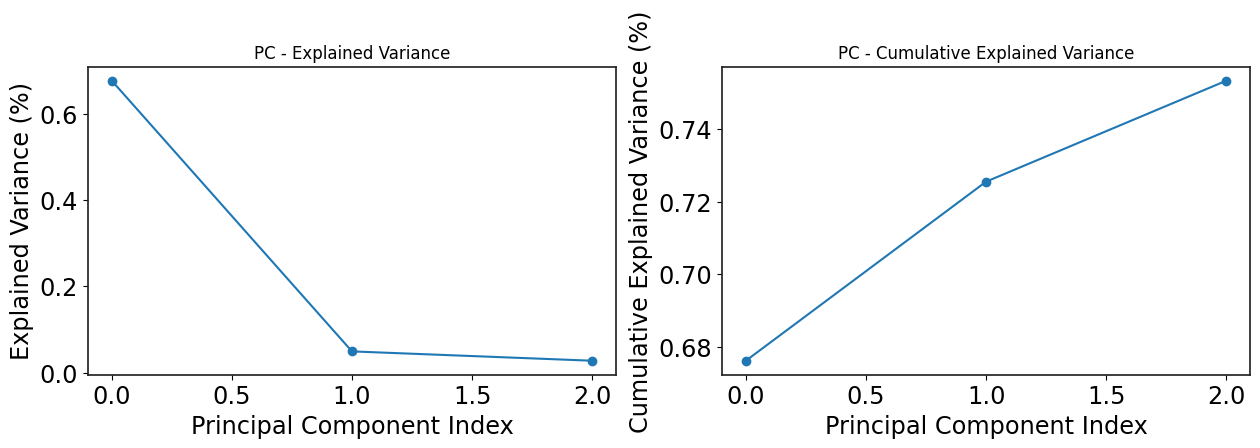

In [772]:
sk_expl_var = np.round(pca.explained_variance_ratio_ * 100, 2)
print([f'{re}%' for re in sk_expl_var])


import matplotlib.pyplot as plt

def plot_explained_variance(pca_explained_variance_ratio_):
    fig, ax = plt.subplots(1,2,figsize=[15,4])

    ax[0].plot(pca_explained_variance_ratio_)
    ax[0].scatter(range(len(pca_explained_variance_ratio_)), pca_explained_variance_ratio_)
    ax[0].set_title('PC - Explained Variance')
    ax[0].set_xlabel('Principal Component Index')
    ax[0].set_ylabel('Explained Variance (%)');

    accumulative_expl_var = []
    for i in range(len(pca_explained_variance_ratio_)):
        accumulative_expl_var.append(np.sum(pca_explained_variance_ratio_[:i+1]))
    ax[1].plot(accumulative_expl_var)
    ax[1].scatter(range(len(accumulative_expl_var)), accumulative_expl_var)
    ax[1].set_title('PC - Cumulative Explained Variance')
    ax[1].set_xlabel('Principal Component Index')
    ax[1].set_ylabel('Cumulative Explained Variance (%)'); 
    
plot_explained_variance(pca.explained_variance_ratio_)

In [773]:
# Example of 
classifiers = {
    'Gaussiann Mixture Model (GMM)':
       GaussianMixture(n_components=4, covariance_type='full', random_state=None),
    'K Nearest Neighbors (KNN)': KNN(contamination=0.05, method='mean', n_neighbors= 20, metric='minkowski', algorithm='kd_tree'),
    'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=0.05, n_bins=20, alpha=0.5),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=15), contamination=0.05),
    
    'Isolation Forest': IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=400,  max_features=1.0, max_samples=1000), 
    'One class SVM (OCSVM)': OCSVM(contamination=0.05, kernel='rbf' , nu= 0.5, degree=10, gamma=6), # OCSVM(contamination=0.05, kernel='rbf' ,
    'Local Outlier Factor (LOF)':
       LOF(n_neighbors=5, contamination=0.05),
     'CBLOF': CBLOF(contamination=0.05,  alpha=0.9, beta=4, n_clusters=5)
}

/content/pyod/pyod/models/knn.py:160: FutureWarning: algorithm parameter is deprecated and will be removed in version 0.7.6. By default, ball_tree will be used.
  FutureWarning)


In [776]:
classifiers = {
    'Gaussiann Mixture Model (GMM)': GMM(n_components= 6, covariance_type='spherical', random_state=0), 
    'K Nearest Neighbors (KNN)': KNN(contamination=0.05, method='mean', n_neighbors= 17, metric='minkowski', algorithm='kd_tree'),
    'Histogram-base Outlier Detection (HBOS)':  HBOS(contamination=0.05, n_bins=15, alpha=0.7), 
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=8), contamination=0.05,  random_state=0),
    'Isolation Forest': IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=100,  max_features=1.0, max_samples=1000, random_state=0),
    'One class SVM (OCSVM)': OCSVM(contamination=0.05, kernel='rbf' , nu= 0.5, degree=10, gamma=7), 
    'Local Outlier Factor (LOF)':
       LOF(n_neighbors=10, contamination=0.05), 
    'CBLOF':  CBLOF(contamination=0.05,  beta=4, n_clusters=10)
 }

/content/pyod/pyod/models/knn.py:160: FutureWarning: algorithm parameter is deprecated and will be removed in version 0.7.6. By default, ball_tree will be used.
  FutureWarning)


In [779]:
clf1 = GMM(n_components=6, covariance_type='spherical', random_state=0)
clf2 =  KNN(contamination=0.05, method='mean', n_neighbors= 17, metric='minkowski', algorithm='kd_tree')
clf3 = HBOS(contamination=0.05, n_bins=15, alpha=0.7)
clf4 = FeatureBagging(LOF(n_neighbors=8), contamination=0.05)
clf5 = IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=200,  max_features=1.0, max_samples=1000)
clf6 = OCSVM(contamination=0.05, kernel='rbf' , nu= 0.5, degree=10, gamma=7)
clf7 = LOF(n_neighbors=10, contamination=0.05)
clf8 = CBLOF(contamination=0.05,  beta=4, n_clusters=10)

/content/pyod/pyod/models/knn.py:160: FutureWarning: algorithm parameter is deprecated and will be removed in version 0.7.6. By default, ball_tree will be used.
  FutureWarning)


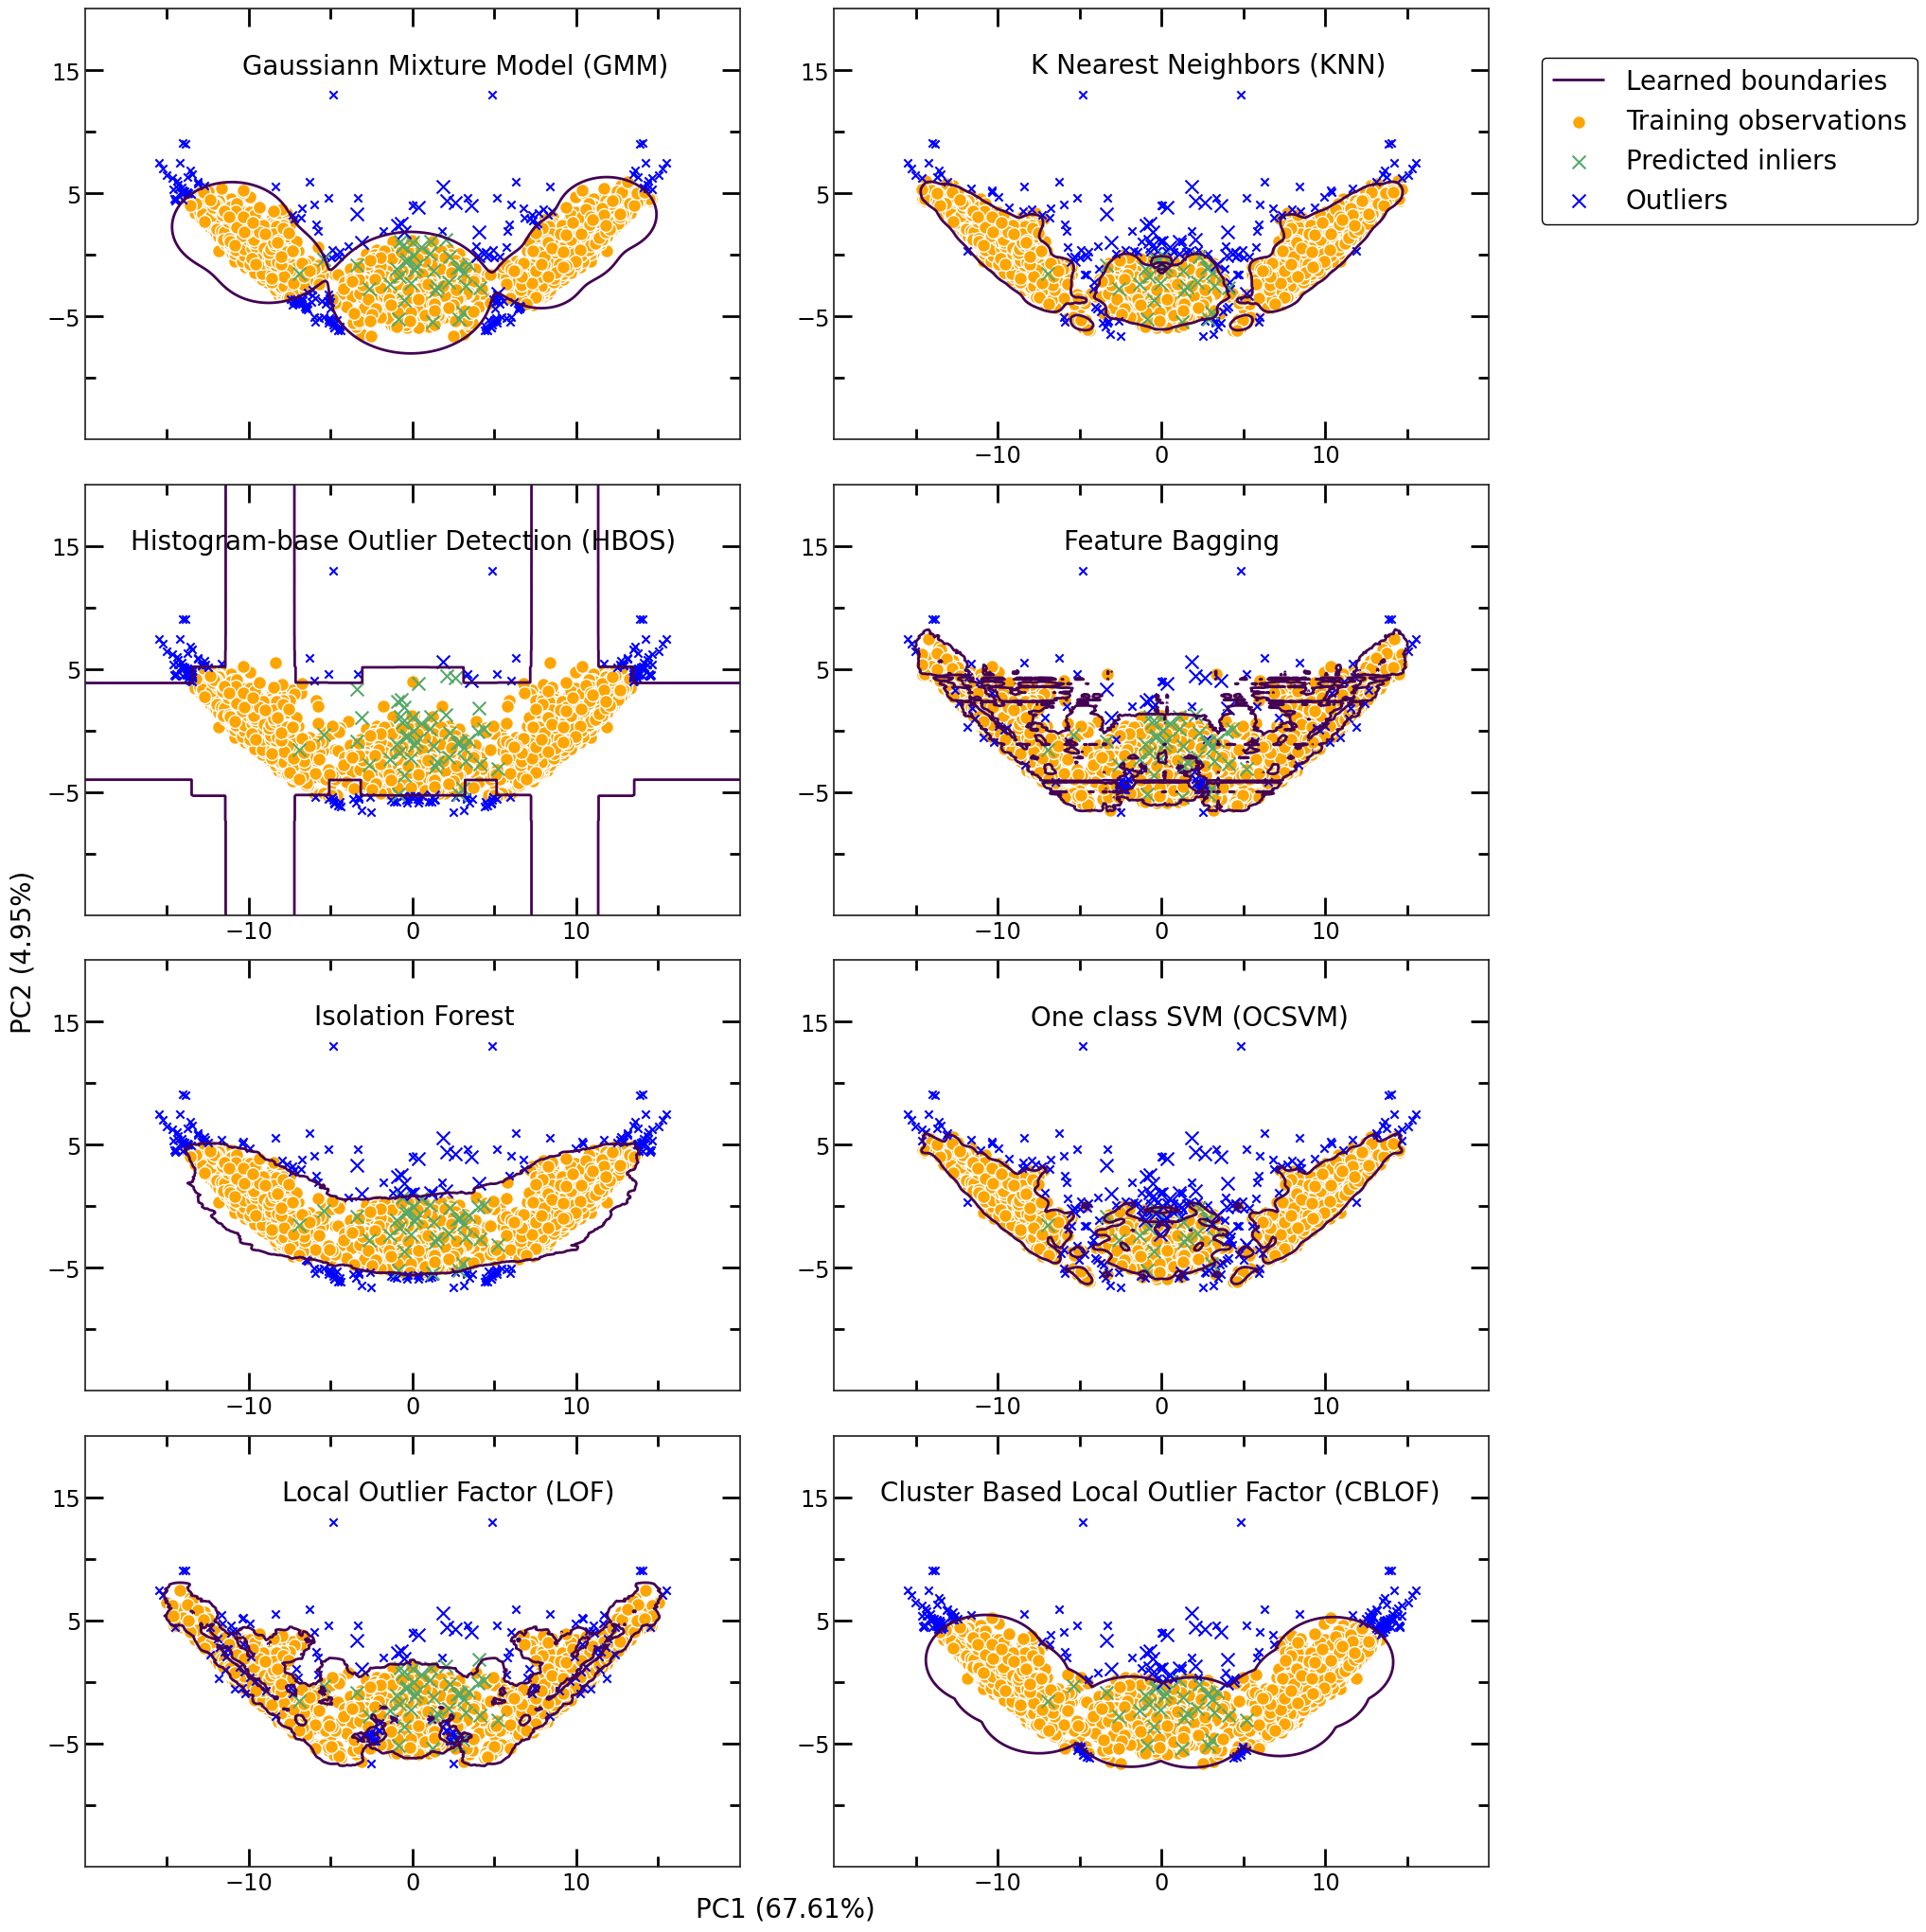

In [780]:
import matplotlib.font_manager
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams["axes.labelsize"] = "xx-large"
plt.rcParams["axes.labelweight"]= "normal"
plt.rcParams["xtick.labelsize"] = "xx-large"
plt.rcParams["ytick.labelsize"] = "xx-large"
X_train = np.array(pd.concat([pd.DataFrame(pc_df)[0],pd.DataFrame(pc_df)[1]], axis=1))
outliers_fraction=0.05
uf_pc = pd.DataFrame(pc_uf)

### Randomly select some point from the unlabelled to plot
uf_pc = uf_pc.sample(n = 50, random_state=1)
X_test =  np.array(pd.concat([uf_pc[0],uf_pc[1]], axis=1))

fig, axes = plt.subplots(figsize=(20,20),nrows=4, ncols=2,constrained_layout=True, gridspec_kw = {'wspace':0.25, 'hspace':0.25})
ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7 = axes.flatten() 

# GMM
clf1.fit(X_train,pd.DataFrame(np.zeros(len(X_train))))
xx, yy = np.meshgrid(np.linspace(-20, 40, 500), np.linspace(-20, 40, 500))  
scores_pred =  clf1.score_samples(X_train) #* -1
threshold = percentile(scores_pred, 100 * outliers_fraction)
k1=clf1.predict(X_train)
X_train_all = pd.concat([pd.DataFrame(X_train, columns=['PC1', 'PC2']), pd.DataFrame(k1, columns=['score'])], axis=1)
X_train_in = X_train_all[X_train_all.score==0]
X_train_out = X_train_all[X_train_all.score==1]
k=clf1.predict(X_test)
scores_pred_t =  clf1.score_samples(X_test) #* -1
#k = (scores_pred_t  > threshold).astype('int').ravel()
X_test_all = pd.concat([pd.DataFrame(X_test, columns=['PC1', 'PC2']), pd.DataFrame(k, columns=['score'])], axis=1)
X_test_in = X_test_all[X_test_all.score==0]
X_test_out = X_test_all[X_test_all.score==1]
Z = clf1.score_samples(np.c_[xx.ravel(), yy.ravel()]) #* -1
Z = Z.reshape(xx.shape)
a = ax0.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, color='red')
b = ax0.scatter(X_train_in.iloc[:, 0], X_train_in.iloc[:, 1], c='orange', marker='o', s=100, linewidths=1,  edgecolors='white')
b1 = ax0.scatter(X_train_out.iloc[:, 0], X_train_out.iloc[:, 1], c='blue', marker='x')#, s=18, linewidths=100)
c = ax0.scatter(X_test_in.iloc[:, 0], X_test_in.iloc[:, 1], c='g', marker='x', s=100)#, linewidths=100000)
d = ax0.scatter(X_test_out.iloc[:, 0], X_test_out.iloc[:, 1], c='blue', marker='x', s=100)#, linewidths=100)
ax0.set_xlim((-20, 20))
ax0.set_ylim((-15, 20))
ax0.tick_params(axis = 'both', which='both', width=2)
ax0.tick_params(axis='x', colors='black')
ax0.tick_params(axis = 'both', which='major', length=14)
ax0.tick_params(axis = 'both', which='minor', length=8, color='black')
ax0.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(-20, 20.5, 10)
minor_ticks_x = np.arange(-20, 20.5, 5)
major_ticks_y = np.arange(-15, 25, 10)
minor_ticks_y = np.arange(-15, 25, 5)
ax0.set_xticks(major_ticks_x)
ax0.set_xticks(minor_ticks_x, minor=True)
ax0.set_yticks(major_ticks_y)
ax0.set_yticks(minor_ticks_y, minor=True)
ax0.set_xticklabels([])
ax0.text(0.24, 0.85, 'Gaussiann Mixture Model (GMM)', 
        transform=ax0.transAxes, ha="left", fontsize=20)
ax0.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax0.yaxis.get_major_ticks()[0].draw = lambda *args:None
ax0.xaxis.get_major_ticks()[-1].draw = lambda *args:None
ax0.yaxis.get_minor_ticks()[-1].draw = lambda *args:None

#KNN
clf2.fit(X_train)
xx, yy = np.meshgrid(np.linspace(-20, 40, 500), np.linspace(-20, 40, 500))  
scores_pred =  clf2.decision_function(X_train) * -1
threshold = percentile(scores_pred, 100 * outliers_fraction)
k2=clf2.predict(X_train)
X_train_all = pd.concat([pd.DataFrame(X_train, columns=['PC1', 'PC2']), pd.DataFrame(k2, columns=['score'])], axis=1)
X_train_in = X_train_all[X_train_all.score==0]
X_train_out = X_train_all[X_train_all.score==1]
k=clf2.predict(X_test)
scores_pred_t =  clf2.decision_function(X_test) * -1
#k = (scores_pred_t  > threshold).astype('int').ravel()
X_test_all = pd.concat([pd.DataFrame(X_test, columns=['PC1', 'PC2']), pd.DataFrame(k, columns=['score'])], axis=1)
X_test_in = X_test_all[X_test_all.score==0]
X_test_out = X_test_all[X_test_all.score==1]
Z = clf2.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
a = ax1.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, color='red')
b = ax1.scatter(X_train_in.iloc[:, 0], X_train_in.iloc[:, 1], c='orange', marker='o', s=100, linewidths=1,  edgecolors='white')
b1 = ax1.scatter(X_train_out.iloc[:, 0], X_train_out.iloc[:, 1], c='blue', marker='x')#, s=18, linewidths=100)
c = ax1.scatter(X_test_in.iloc[:, 0], X_test_in.iloc[:, 1], c='g', marker='x', s=100)#, linewidths=100000)
d = ax1.scatter(X_test_out.iloc[:, 0], X_test_out.iloc[:, 1], c='blue', marker='x', s=100)#, linewidths=100)
ax1.set_xlim((-20, 20))
ax1.set_ylim((-15, 20))
ax1.tick_params(axis = 'both', which='both', width=2)
ax1.tick_params(axis='x', colors='black')
ax1.tick_params(axis = 'both', which='major', length=14)
ax1.tick_params(axis = 'both', which='minor', length=8, color='black')
ax1.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True,  direction='in')
major_ticks_x = np.arange(-20, 20.5, 10)
minor_ticks_x = np.arange(-20, 20.5, 5)
major_ticks_y = np.arange(-15, 25, 10)
minor_ticks_y = np.arange(-15, 25, 5)
ax1.set_xticks(major_ticks_x)
ax1.set_xticks(minor_ticks_x, minor=True)
ax1.set_yticks(major_ticks_y)
ax1.set_yticks(minor_ticks_y, minor=True)
ax1.text(0.3, 0.85, 'K Nearest Neighbors (KNN)', 
        transform=ax1.transAxes, ha="left", fontsize=20)
ax1.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax1.xaxis.get_major_ticks()[-1].draw = lambda *args:None
ax1.yaxis.get_major_ticks()[0].draw = lambda *args:None
ax1.yaxis.get_minor_ticks()[-1].draw = lambda *args:None


# HBOS
clf3.fit(X_train)
xx, yy = np.meshgrid(np.linspace(-20, 40, 500), np.linspace(-20, 40, 500))  
scores_pred =  clf3.decision_function(X_train) * -1
threshold = percentile(scores_pred, 100 * outliers_fraction)
k2=clf3.predict(X_train)
X_train_all = pd.concat([pd.DataFrame(X_train, columns=['PC1', 'PC2']), pd.DataFrame(k2, columns=['score'])], axis=1)
X_train_in = X_train_all[X_train_all.score==0]
X_train_out = X_train_all[X_train_all.score==1]
k=clf3.predict(X_test)
scores_pred_t =  clf3.decision_function(X_test) * -1
#k = (scores_pred_t  > threshold).astype('int').ravel()
X_test_all = pd.concat([pd.DataFrame(X_test, columns=['PC1', 'PC2']), pd.DataFrame(k, columns=['score'])], axis=1)
X_test_in = X_test_all[X_test_all.score==0]
X_test_out = X_test_all[X_test_all.score==1]
Z = clf3.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
a = ax2.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, color='red')
b = ax2.scatter(X_train_in.iloc[:, 0], X_train_in.iloc[:, 1], c='orange', marker='o', s=100, linewidths=1,  edgecolors='white')
b1 = ax2.scatter(X_train_out.iloc[:, 0], X_train_out.iloc[:, 1], c='blue', marker='x')#, s=18, linewidths=100)
c = ax2.scatter(X_test_in.iloc[:, 0], X_test_in.iloc[:, 1], c='g', marker='x', s=100)#, linewidths=100000)
d = ax2.scatter(X_test_out.iloc[:, 0], X_test_out.iloc[:, 1], c='blue', marker='x', s=100)#, linewidths=100)
ax2.set_xlim((-20, 20))
ax2.set_ylim((-15, 20))

ax2.tick_params(axis = 'both', which='both', width=2)
ax2.tick_params(axis='x', colors='black')
ax2.tick_params(axis = 'both', which='major', length=14)
ax2.tick_params(axis = 'both', which='minor', length=8, color='black')
ax2.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True,  direction='in')
major_ticks_x = np.arange(-20, 20.5, 10)
minor_ticks_x = np.arange(-20, 20.5, 5)
major_ticks_y = np.arange(-15, 25, 10)
minor_ticks_y = np.arange(-15, 25, 5)
ax2.set_xticks(major_ticks_x)
ax2.set_xticks(minor_ticks_x, minor=True)
ax2.set_yticks(major_ticks_y)
ax2.set_yticks(minor_ticks_y, minor=True)
ax2.text(0.07, 0.85, 'Histogram-base Outlier Detection (HBOS)', 
        transform=ax2.transAxes, ha="left", fontsize=20)
ax2.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax2.xaxis.get_major_ticks()[-1].draw = lambda *args:None
ax2.yaxis.get_major_ticks()[0].draw = lambda *args:None
ax2.yaxis.get_minor_ticks()[-1].draw = lambda *args:None



#FeatureBagging
clf4.fit(X_train)
xx, yy = np.meshgrid(np.linspace(-20, 40, 500), np.linspace(-20, 40, 500))  
scores_pred =  clf4.decision_function(X_train) * -1
threshold = percentile(scores_pred, 100 * outliers_fraction)
k2=clf4.predict(X_train)
X_train_all = pd.concat([pd.DataFrame(X_train, columns=['PC1', 'PC2']), pd.DataFrame(k2, columns=['score'])], axis=1)
X_train_in = X_train_all[X_train_all.score==0]
X_train_out = X_train_all[X_train_all.score==1]
k=clf4.predict(X_test)
scores_pred_t =  clf4.decision_function(X_test) * -1
#k = (scores_pred_t  > threshold).astype('int').ravel()
X_test_all = pd.concat([pd.DataFrame(X_test, columns=['PC1', 'PC2']), pd.DataFrame(k, columns=['score'])], axis=1)
X_test_in = X_test_all[X_test_all.score==0]
X_test_out = X_test_all[X_test_all.score==1]
Z = clf4.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
a = ax3.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, color='red')
b = ax3.scatter(X_train_in.iloc[:, 0], X_train_in.iloc[:, 1], c='orange', marker='o', s=100, linewidths=1,  edgecolors='white')
b1 = ax3.scatter(X_train_out.iloc[:, 0], X_train_out.iloc[:, 1], c='blue', marker='x')#, s=18, linewidths=100)
c = ax3.scatter(X_test_in.iloc[:, 0], X_test_in.iloc[:, 1], c='g', marker='x', s=100)#, linewidths=100000)
d = ax3.scatter(X_test_out.iloc[:, 0], X_test_out.iloc[:, 1], c='blue', marker='x', s=100)#, linewidths=100)
ax3.set_xlim((-20, 20))
ax3.set_ylim((-15, 20))
ax3.tick_params(axis = 'both', which='both', width=2)
ax3.tick_params(axis='x', colors='black')
ax3.tick_params(axis = 'both', which='major', length=14)
ax3.tick_params(axis = 'both', which='minor', length=8, color='black')
ax3.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True,  direction='in')
major_ticks_x = np.arange(-20, 20.5, 10)
minor_ticks_x = np.arange(-20, 20.5, 5)
major_ticks_y = np.arange(-15, 25, 10)
minor_ticks_y = np.arange(-15, 25, 5)
ax3.set_xticks(major_ticks_x)
ax3.set_xticks(minor_ticks_x, minor=True)
ax3.set_yticks(major_ticks_y)
ax3.set_yticks(minor_ticks_y, minor=True)
ax3.text(0.35, 0.85, 'Feature Bagging', 
        transform=ax3.transAxes, ha="left", fontsize=20)
ax3.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax3.xaxis.get_major_ticks()[-1].draw = lambda *args:None
ax3.yaxis.get_major_ticks()[0].draw = lambda *args:None
ax3.yaxis.get_minor_ticks()[-1].draw = lambda *args:None


# IForest
clf5.fit(X_train)
xx, yy = np.meshgrid(np.linspace(-20, 40, 500), np.linspace(-20, 40, 500))  
scores_pred =  clf5.decision_function(X_train) * -1
threshold = percentile(scores_pred, 100 * outliers_fraction)
k2=clf5.predict(X_train)
X_train_all = pd.concat([pd.DataFrame(X_train, columns=['PC1', 'PC2']), pd.DataFrame(k2, columns=['score'])], axis=1)
X_train_in = X_train_all[X_train_all.score==0]
X_train_out = X_train_all[X_train_all.score==1]
k=clf5.predict(X_test)
scores_pred_t =  clf5.decision_function(X_test) * -1
#k = (scores_pred_t  > threshold).astype('int').ravel()
X_test_all = pd.concat([pd.DataFrame(X_test, columns=['PC1', 'PC2']), pd.DataFrame(k, columns=['score'])], axis=1)
X_test_in = X_test_all[X_test_all.score==0]
X_test_out = X_test_all[X_test_all.score==1]
Z = clf5.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
a = ax4.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, color='red')
b = ax4.scatter(X_train_in.iloc[:, 0], X_train_in.iloc[:, 1], c='orange', marker='o', s=100, linewidths=1,  edgecolors='white')
b1 = ax4.scatter(X_train_out.iloc[:, 0], X_train_out.iloc[:, 1], c='blue', marker='x')#, s=18, linewidths=100)
c = ax4.scatter(X_test_in.iloc[:, 0], X_test_in.iloc[:, 1], c='g', marker='x', s=100)#, linewidths=100000)
d = ax4.scatter(X_test_out.iloc[:, 0], X_test_out.iloc[:, 1], c='blue', marker='x', s=100)#, linewidths=100)
ax4.set_xlim((-20, 20))
ax4.set_ylim((-15, 20))
ax4.tick_params(axis = 'both', which='both', width=2)
ax4.tick_params(axis='x', colors='black')
ax4.tick_params(axis = 'both', which='major', length=14)
ax4.tick_params(axis = 'both', which='minor', length=8, color='black')
ax4.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True,  direction='in')
major_ticks_x = np.arange(-20, 20.5, 10)
minor_ticks_x = np.arange(-20, 20.5, 5)
major_ticks_y = np.arange(-15, 25, 10)
minor_ticks_y = np.arange(-15, 25, 5)
ax4.set_xticks(major_ticks_x)
ax4.set_xticks(minor_ticks_x, minor=True)
ax4.set_yticks(major_ticks_y)
ax4.set_yticks(minor_ticks_y, minor=True)
ax4.text(0.35, 0.85, 'Isolation Forest', 
        transform=ax4.transAxes, ha="left", fontsize=20)
ax4.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax4.xaxis.get_major_ticks()[-1].draw = lambda *args:None
ax4.yaxis.get_major_ticks()[0].draw = lambda *args:None
ax4.yaxis.get_minor_ticks()[-1].draw = lambda *args:None



# OCSVM
clf6.fit(X_train)
xx, yy = np.meshgrid(np.linspace(-20, 40, 500), np.linspace(-20, 40, 500))  
scores_pred =  clf6.decision_function(X_train) * -1
threshold = percentile(scores_pred, 100 * outliers_fraction)
k2=clf6.predict(X_train)
X_train_all = pd.concat([pd.DataFrame(X_train, columns=['PC1', 'PC2']), pd.DataFrame(k2, columns=['score'])], axis=1)
X_train_in = X_train_all[X_train_all.score==0]
X_train_out = X_train_all[X_train_all.score==1]
k=clf6.predict(X_test)
scores_pred_t =  clf6.decision_function(X_test) * -1
#k = (scores_pred_t  > threshold).astype('int').ravel()
X_test_all = pd.concat([pd.DataFrame(X_test, columns=['PC1', 'PC2']), pd.DataFrame(k, columns=['score'])], axis=1)
X_test_in = X_test_all[X_test_all.score==0]
X_test_out = X_test_all[X_test_all.score==1]
Z = clf6.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
a = ax5.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, color='red')
b = ax5.scatter(X_train_in.iloc[:, 0], X_train_in.iloc[:, 1], c='orange', marker='o', s=100, linewidths=1,  edgecolors='white')
b1 = ax5.scatter(X_train_out.iloc[:, 0], X_train_out.iloc[:, 1], c='blue', marker='x')#, s=18, linewidths=100)
c = ax5.scatter(X_test_in.iloc[:, 0], X_test_in.iloc[:, 1], c='g', marker='x', s=100)#, linewidths=100000)
d = ax5.scatter(X_test_out.iloc[:, 0], X_test_out.iloc[:, 1], c='blue', marker='x', s=100)#, linewidths=100)
ax5.set_xlim((-20, 20))
ax5.set_ylim((-15, 20))
ax5.tick_params(axis = 'both', which='both', width=2)
ax5.tick_params(axis='x', colors='black')
ax5.tick_params(axis = 'both', which='major', length=14)
ax5.tick_params(axis = 'both', which='minor', length=8, color='black')
ax5.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True,  direction='in')
major_ticks_x = np.arange(-20, 20.5, 10)
minor_ticks_x = np.arange(-20, 20.5, 5)
major_ticks_y = np.arange(-15, 25, 10)
minor_ticks_y = np.arange(-15, 25, 5)
ax5.set_xticks(major_ticks_x)
ax5.set_xticks(minor_ticks_x, minor=True)
ax5.set_yticks(major_ticks_y)
ax5.set_yticks(minor_ticks_y, minor=True)
ax5.text(0.3, 0.85, 'One class SVM (OCSVM)', 
        transform=ax5.transAxes, ha="left", fontsize=20)
ax5.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax5.xaxis.get_major_ticks()[-1].draw = lambda *args:None
ax5.yaxis.get_major_ticks()[0].draw = lambda *args:None
ax5.yaxis.get_minor_ticks()[-1].draw = lambda *args:None


# LOF
clf7.fit(X_train)
xx, yy = np.meshgrid(np.linspace(-20, 40, 500), np.linspace(-20, 40, 500))  
scores_pred =  clf7.decision_function(X_train) * -1
threshold = percentile(scores_pred, 100 * outliers_fraction)
k2=clf7.predict(X_train)
X_train_all = pd.concat([pd.DataFrame(X_train, columns=['PC1', 'PC2']), pd.DataFrame(k2, columns=['score'])], axis=1)
X_train_in = X_train_all[X_train_all.score==0]
X_train_out = X_train_all[X_train_all.score==1]
k=clf7.predict(X_test)
scores_pred_t =  clf7.decision_function(X_test) * -1
X_test_all = pd.concat([pd.DataFrame(X_test, columns=['PC1', 'PC2']), pd.DataFrame(k, columns=['score'])], axis=1)
X_test_in = X_test_all[X_test_all.score==0]
X_test_out = X_test_all[X_test_all.score==1]
Z = clf7.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
a = ax6.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, color='red')
b = ax6.scatter(X_train_in.iloc[:, 0], X_train_in.iloc[:, 1], c='orange', marker='o', s=100, linewidths=1,  edgecolors='white')
b1 = ax6.scatter(X_train_out.iloc[:, 0], X_train_out.iloc[:, 1], c='blue', marker='x')#, s=18, linewidths=100)
c = ax6.scatter(X_test_in.iloc[:, 0], X_test_in.iloc[:, 1], c='g', marker='x', s=100)#, linewidths=100000)
d = ax6.scatter(X_test_out.iloc[:, 0], X_test_out.iloc[:, 1], c='blue', marker='x', s=100)#, linewidths=100)
ax6.set_xlim((-20, 20))
ax6.set_ylim((-15, 20))
ax6.tick_params(axis = 'both', which='both', width=2)
ax6.tick_params(axis='x', colors='black')
ax6.tick_params(axis = 'both', which='major', length=14)
ax6.tick_params(axis = 'both', which='minor', length=8, color='black')
ax6.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True,  direction='in')
major_ticks_x = np.arange(-20, 20.5, 10)
minor_ticks_x = np.arange(-20, 20.5, 5)
major_ticks_y = np.arange(-15, 25, 10)
minor_ticks_y = np.arange(-15, 25, 5)
ax6.set_xticks(major_ticks_x)
ax6.set_xticks(minor_ticks_x, minor=True)
ax6.set_yticks(major_ticks_y)
ax6.set_yticks(minor_ticks_y, minor=True)
ax6.text(0.3, 0.85, 'Local Outlier Factor (LOF)', 
        transform=ax6.transAxes, ha="left", fontsize=20)
ax6.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax6.xaxis.get_major_ticks()[-1].draw = lambda *args:None
ax6.yaxis.get_major_ticks()[0].draw = lambda *args:None
ax6.yaxis.get_minor_ticks()[-1].draw = lambda *args:None


# CBLOF
clf8.fit(X_train)
xx, yy = np.meshgrid(np.linspace(-20, 40, 500), np.linspace(-20, 40, 500))  
scores_pred =  clf8.decision_function(X_train) * -1
threshold = percentile(scores_pred, 100 * outliers_fraction)
k2=clf8.predict(X_train)
X_train_all = pd.concat([pd.DataFrame(X_train, columns=['PC1', 'PC2']), pd.DataFrame(k2, columns=['score'])], axis=1)
X_train_in = X_train_all[X_train_all.score==0]
X_train_out = X_train_all[X_train_all.score==1]
k=clf8.predict(X_test)
scores_pred_t =  clf8.decision_function(X_test) * -1
#k = (scores_pred_t  > threshold).astype('int').ravel()
X_test_all = pd.concat([pd.DataFrame(X_test, columns=['PC1', 'PC2']), pd.DataFrame(k, columns=['score'])], axis=1)
X_test_in = X_test_all[X_test_all.score==0]
X_test_out = X_test_all[X_test_all.score==1]
Z = clf8.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
a = ax7.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, color='red')
b = ax7.scatter(X_train_in.iloc[:, 0], X_train_in.iloc[:, 1], c='orange', marker='o', s=100, linewidths=1,  edgecolors='white')
b1 = ax7.scatter(X_train_out.iloc[:, 0], X_train_out.iloc[:, 1], c='blue', marker='x')#, s=18, linewidths=100)
c = ax7.scatter(X_test_in.iloc[:, 0], X_test_in.iloc[:, 1], c='g', marker='x', s=100)#, linewidths=100000)
d = ax7.scatter(X_test_out.iloc[:, 0], X_test_out.iloc[:, 1], c='blue', marker='x', s=100)#, linewidths=100)
ax7.set_xlim((-20, 20))
ax7.set_ylim((-15, 20))
ax7.tick_params(axis = 'both', which='both', width=2)
ax7.tick_params(axis='x', colors='black')
ax7.tick_params(axis = 'both', which='major', length=14)
ax7.tick_params(axis = 'both', which='minor', length=8, color='black')
ax7.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True,  direction='in')
major_ticks_x = np.arange(-20, 20.5, 10)
minor_ticks_x = np.arange(-20, 20.5, 5)
major_ticks_y = np.arange(-15, 25, 10)
minor_ticks_y = np.arange(-15, 25, 5)
ax7.set_xticks(major_ticks_x)
ax7.set_xticks(minor_ticks_x, minor=True)
ax7.set_yticks(major_ticks_y)
ax7.set_yticks(minor_ticks_y, minor=True)
ax7.text(0.07, 0.85, 'Cluster Based Local Outlier Factor (CBLOF)', 
        transform=ax7.transAxes, ha="left", fontsize=20)
ax7.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax7.xaxis.get_major_ticks()[-1].draw = lambda *args:None
ax7.yaxis.get_major_ticks()[0].draw = lambda *args:None
ax7.yaxis.get_minor_ticks()[-1].draw = lambda *args:None



#plt.legend(prop={'size': 20}, loc=(0.45, 0.75), facecolor='white', framealpha=1)

ax1.legend([a.collections[0], b, c, d],
           ["Learned boundaries", "Training observations", "Predicted inliers", "Outliers"], 
           prop=matplotlib.font_manager.FontProperties(size=20),loc=(1.08, 0.5), facecolor='white', framealpha=1, edgecolor='black' )

fig.text(0.4, -0.01, 'PC1 (67.61%)', ha='center', fontsize=20)  
fig.text(-0.01, 0.5, 'PC2 (4.95%)', va='center', rotation='vertical', fontsize=20)

plt.tight_layout()
#plt.savefig('/content/drive/My Drive/pca_plt.png', rasterized=True,  bbox_inches="tight", dpi=600)
plt.show()

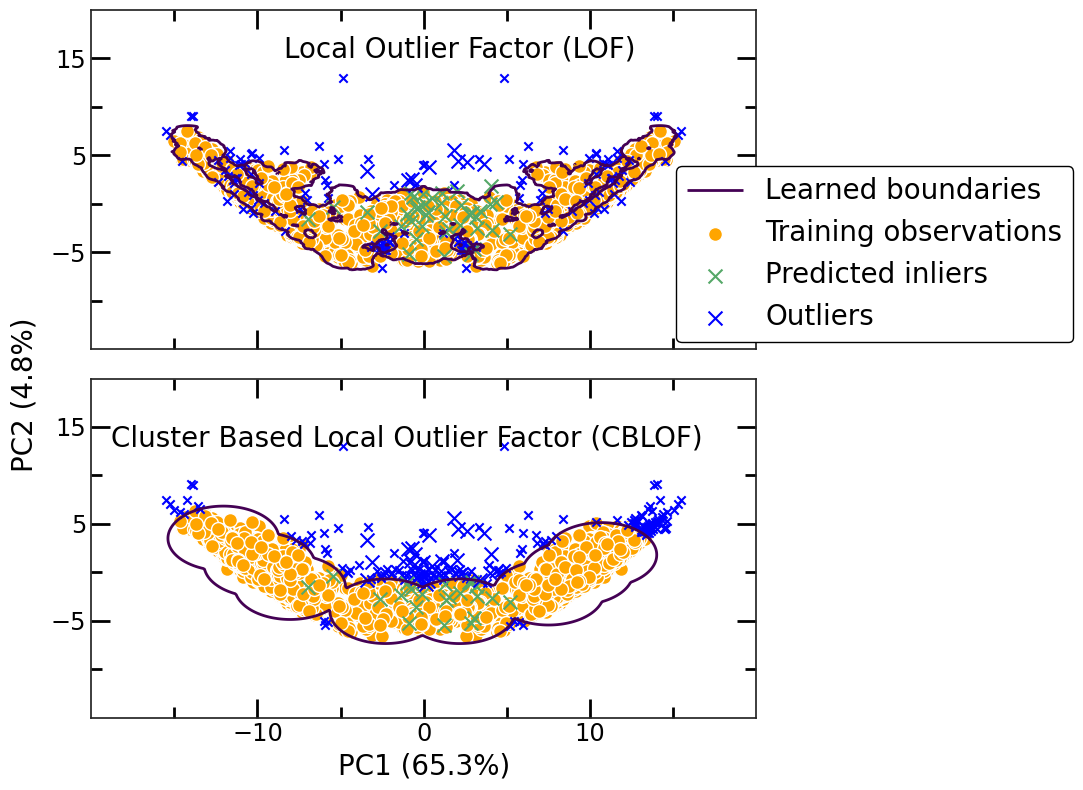

In [801]:
import matplotlib.font_manager
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams["axes.labelsize"] = "xx-large"
plt.rcParams["axes.labelweight"]= "normal"
plt.rcParams["xtick.labelsize"] = "xx-large"
plt.rcParams["ytick.labelsize"] = "xx-large"
X_train = np.array(pd.concat([pd.DataFrame(pc_df)[0],pd.DataFrame(pc_df)[1]], axis=1))
outliers_fraction=0.05
uf_pc = pd.DataFrame(pc_uf)

### Randomly select some point from the unlabelled to plot
uf_pc = uf_pc.sample(n = 50, random_state=1)
X_test =  np.array(pd.concat([uf_pc[0],uf_pc[1]], axis=1))


#fig, axes = plt.subplots(figsize=(10,7),nrows=2, ncols=1,constrained_layout=True)#,gridspec_kw = {'wspace':0.05, 'hspace':0.1})
#ax0, ax1 = axes.flatten()
#fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
#fig.subplots_adjust( subplot_kw=dict(box_aspect=1) )

fig = plt.figure(figsize=(10.5,8))
fig.subplots_adjust(wspace=0, hspace=0)
ax0 = fig.add_subplot(2,1,1, adjustable='box')#, aspect=0.3)
ax1 = fig.add_subplot(2,1,2)
clf1 = LOF(n_neighbors=10, contamination=0.05)
clf2 = CBLOF(contamination=0.05,  beta=4, n_clusters=10)

# LOF
clf1.fit(X_train)
xx, yy = np.meshgrid(np.linspace(-20, 40, 500), np.linspace(-20, 40, 500))  
scores_pred =  clf1.decision_function(X_train) * -1
threshold = percentile(scores_pred, 100 * outliers_fraction)
k1=clf1.predict(X_train)
X_train_all = pd.concat([pd.DataFrame(X_train, columns=['PC1', 'PC2']), pd.DataFrame(k1, columns=['score'])], axis=1)
X_train_in = X_train_all[X_train_all.score==0]
X_train_out = X_train_all[X_train_all.score==1]
k=clf1.predict(X_test)
scores_pred_t =  clf1.decision_function(X_test) * -1
#k = (scores_pred_t  > threshold).astype('int').ravel()
X_test_all = pd.concat([pd.DataFrame(X_test, columns=['PC1', 'PC2']), pd.DataFrame(k, columns=['score'])], axis=1)
X_test_in = X_test_all[X_test_all.score==0]
X_test_out = X_test_all[X_test_all.score==1]
Z = clf1.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
a = ax0.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, color='red')
b = ax0.scatter(X_train_in.iloc[:, 0], X_train_in.iloc[:, 1], c='orange', marker='o', s=100, linewidths=1,  edgecolors='white')
b1 = ax0.scatter(X_train_out.iloc[:, 0], X_train_out.iloc[:, 1], c='blue', marker='x')#, s=18, linewidths=100)
c = ax0.scatter(X_test_in.iloc[:, 0], X_test_in.iloc[:, 1], c='g', marker='x', s=100)#, linewidths=100000)
d = ax0.scatter(X_test_out.iloc[:, 0], X_test_out.iloc[:, 1], c='blue', marker='x', s=100)#, linewidths=100)
ax0.set_xlim((-20, 20))
ax0.set_ylim((-15, 20))
#ax0.set_ylabel('PC2 (4.8%)', fontsize=20)
ax0.tick_params(axis = 'both', which='both', width=2)
ax0.tick_params(axis='x', colors='black')
ax0.tick_params(axis = 'both', which='major', length=14)
ax0.tick_params(axis = 'both', which='minor', length=8, color='black')
ax0.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(-20, 20.5, 10)
minor_ticks_x = np.arange(-20, 20.5, 5)
major_ticks_y = np.arange(-15, 25, 10)
minor_ticks_y = np.arange(-15, 25, 5)
ax0.set_xticks(major_ticks_x)
ax0.set_xticks(minor_ticks_x, minor=True)
ax0.set_yticks(major_ticks_y)
ax0.set_yticks(minor_ticks_y, minor=True)
ax0.set_xticklabels([])
ax0.text(0.29, 0.86, 'Local Outlier Factor (LOF)', 
        transform=ax0.transAxes, ha="left", fontsize=20)
ax0.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax0.yaxis.get_major_ticks()[0].draw = lambda *args:None
ax0.xaxis.get_major_ticks()[-1].draw = lambda *args:None
ax0.yaxis.get_minor_ticks()[-1].draw = lambda *args:None

# CBLOF
clf2.fit(X_train)
xx, yy = np.meshgrid(np.linspace(-20, 40, 500), np.linspace(-20, 40, 500))  
scores_pred =  clf2.decision_function(X_train) * -1
threshold = percentile(scores_pred, 100 * outliers_fraction)
k2=clf2.predict(X_train)
X_train_all = pd.concat([pd.DataFrame(X_train, columns=['PC1', 'PC2']), pd.DataFrame(k2, columns=['score'])], axis=1)
X_train_in = X_train_all[X_train_all.score==0]
X_train_out = X_train_all[X_train_all.score==1]
k=clf2.predict(X_test)
scores_pred_t =  clf2.decision_function(X_test) * -1
#k = (scores_pred_t  > threshold).astype('int').ravel()
X_test_all = pd.concat([pd.DataFrame(X_test, columns=['PC1', 'PC2']), pd.DataFrame(k, columns=['score'])], axis=1)
X_test_in = X_test_all[X_test_all.score==0]
X_test_out = X_test_all[X_test_all.score==1]
Z = clf2.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
a = ax1.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, color='red')
b = ax1.scatter(X_train_in.iloc[:, 0], X_train_in.iloc[:, 1], c='orange', marker='o', s=100, linewidths=1,  edgecolors='white')
b1 = ax1.scatter(X_train_out.iloc[:, 0], X_train_out.iloc[:, 1], c='blue', marker='x')#, s=18, linewidths=100)
c = ax1.scatter(X_test_in.iloc[:, 0], X_test_in.iloc[:, 1], c='g', marker='x', s=100)#, linewidths=100000)
d = ax1.scatter(X_test_out.iloc[:, 0], X_test_out.iloc[:, 1], c='blue', marker='x', s=100)#, linewidths=100)
ax1.set_xlim((-20, 20))
ax1.set_ylim((-15, 20))
ax1.set_xlabel('PC1 (65.3%)', fontsize=20)
#ax1.set_ylabel('PC2 (4.8%)',  fontsize=20)
ax1.tick_params(axis = 'both', which='both', width=2)
ax1.tick_params(axis='x', colors='black')
ax1.tick_params(axis = 'both', which='major', length=14)
ax1.tick_params(axis = 'both', which='minor', length=8, color='black')
ax1.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True,  direction='in')
major_ticks_x = np.arange(-20, 20.5, 10)
minor_ticks_x = np.arange(-20, 20.5, 5)
major_ticks_y = np.arange(-15, 25, 10)
minor_ticks_y = np.arange(-15, 25, 5)
ax1.set_xticks(major_ticks_x)
ax1.set_xticks(minor_ticks_x, minor=True)
ax1.set_yticks(major_ticks_y)
ax1.set_yticks(minor_ticks_y, minor=True)
ax1.text(0.03, 0.8, 'Cluster Based Local Outlier Factor (CBLOF)', 
        transform=ax1.transAxes, ha="left", fontsize=20)
ax1.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax1.xaxis.get_major_ticks()[-1].draw = lambda *args:None
ax1.yaxis.get_major_ticks()[0].draw = lambda *args:None
ax1.yaxis.get_minor_ticks()[-1].draw = lambda *args:None
#plt.legend(prop={'size': 20}, loc=(0.45, 0.75), facecolor='white', framealpha=1)

ax0.legend([a.collections[0], b, c, d],
           ["Learned boundaries", "Training observations", "Predicted inliers", "Outliers"], 
           prop=matplotlib.font_manager.FontProperties(size=20),loc=(0.88, 0.02), facecolor='white', framealpha=1, edgecolor='black' )
fig.text(-0.01, 0.5, 'PC2 (4.8%)', va='center', rotation='vertical', fontsize=20)

plt.tight_layout()
#plt.savefig('pca_plt.svg', dpi=600)

The selection of the hyperparameters is performed using hyperopt library and the algorithms are evaluatued using k-fold cross-validations

# Comparison

In [337]:
class GMM(GaussianMixture):
  def __init__(self, n_components, covariance_type, random_state):
    super().__init__(n_components=n_components , covariance_type=covariance_type, random_state=random_state)

  def fit(self, X, y):
    super().fit(X, y)
    self.prob = super().score_samples(X)
    self.c = percentile(self.prob, 100 * contamination)

  def predict(self, X):
    scores = []
    proba=super().score_samples(X)
    
    scores =(proba <= self.c).astype('int').ravel()

    return scores

In [853]:
# The hyperparameters were selected after Bayesian Optimization using the hyperopt library
classifiers = {
    'Gaussiann Mixture Model (GMM)': GMM(n_components= 6, covariance_type='spherical', random_state=0), 
    'K Nearest Neighbors (KNN)': KNN(contamination=0.05, method='mean', n_neighbors= 17, metric='minkowski', algorithm='kd_tree'),
    'Histogram-base Outlier Detection (HBOS)':  HBOS(contamination=0.05, n_bins=15, alpha=0.7), 
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=8), contamination=0.05,  random_state=0),
    'Isolation Forest': IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=400,  max_features=1.0, max_samples=1000, random_state=0),
    'One class SVM (OCSVM)': OCSVM(contamination=0.05, kernel='rbf' , nu= 0.5, degree=10, gamma=7), 
    'Local Outlier Factor (LOF)':
       LOF(n_neighbors=10, contamination=0.05), 
    'CBLOF':  CBLOF(contamination=0.05,  beta=4, n_clusters=10)
 }

/content/pyod/pyod/models/knn.py:160: FutureWarning: algorithm parameter is deprecated and will be removed in version 0.7.6. By default, ball_tree will be used.
  FutureWarning)


In [854]:
contamination=0.05
def fit_predict(X_train, X_test):
  train_scores=[]
  test_scores = []
  min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
  contamination = 0.05
  for i, (clf_name, clf) in enumerate(classifiers.items()):
    if clf_name == 'Gaussiann Mixture Model (GMM)':
      clf.fit(X_train, pd.DataFrame(np.zeros(len(X_train))))
      prob = clf.score_samples(X_train)
      prob = min_max_scaler.fit_transform(np.array(prob).reshape(-1,1))
      prob_t  = clf.score_samples(X_test)
      prob_t = min_max_scaler.transform(np.array(prob_t).reshape(-1,1))
      train_scores.append(prob.ravel())
      test_scores.append(prob_t.ravel())
    else:
      clf.fit(X_train)
      prob=clf.decision_function(X_train) * -1 
      prob = min_max_scaler.fit_transform(np.array(prob).reshape(-1,1))
      prob_t  = clf.decision_function(X_test) * -1
      prob_t = min_max_scaler.transform(np.array(prob_t).reshape(-1,1)) 
      train_scores.append(prob.ravel())
      test_scores.append(prob_t.ravel())
  return train_scores, test_scores
df=df.fillna(0)
X_train= df.iloc[:, 1:]
X_test = uf
train_scores, test_scores = fit_predict(X_train, X_test)

In [855]:
# Assign scores to each classifier
gmm1 = list(train_scores[0]) + list(test_scores[0])
knn1 = list(train_scores[1]) + list(test_scores[1])
hbos1= list(train_scores[2]) + list(test_scores[2]) 
feat_bag1 = list(train_scores[3]) + list(test_scores[3])  
ifor1 =  list(train_scores[4]) + list(test_scores[4]) 
ocsvm1= list(train_scores[5]) + list(test_scores[5])  
lof1 = list(train_scores[6]) + list(test_scores[6])  
cblof1 = list(train_scores[7]) + list(test_scores[7])  


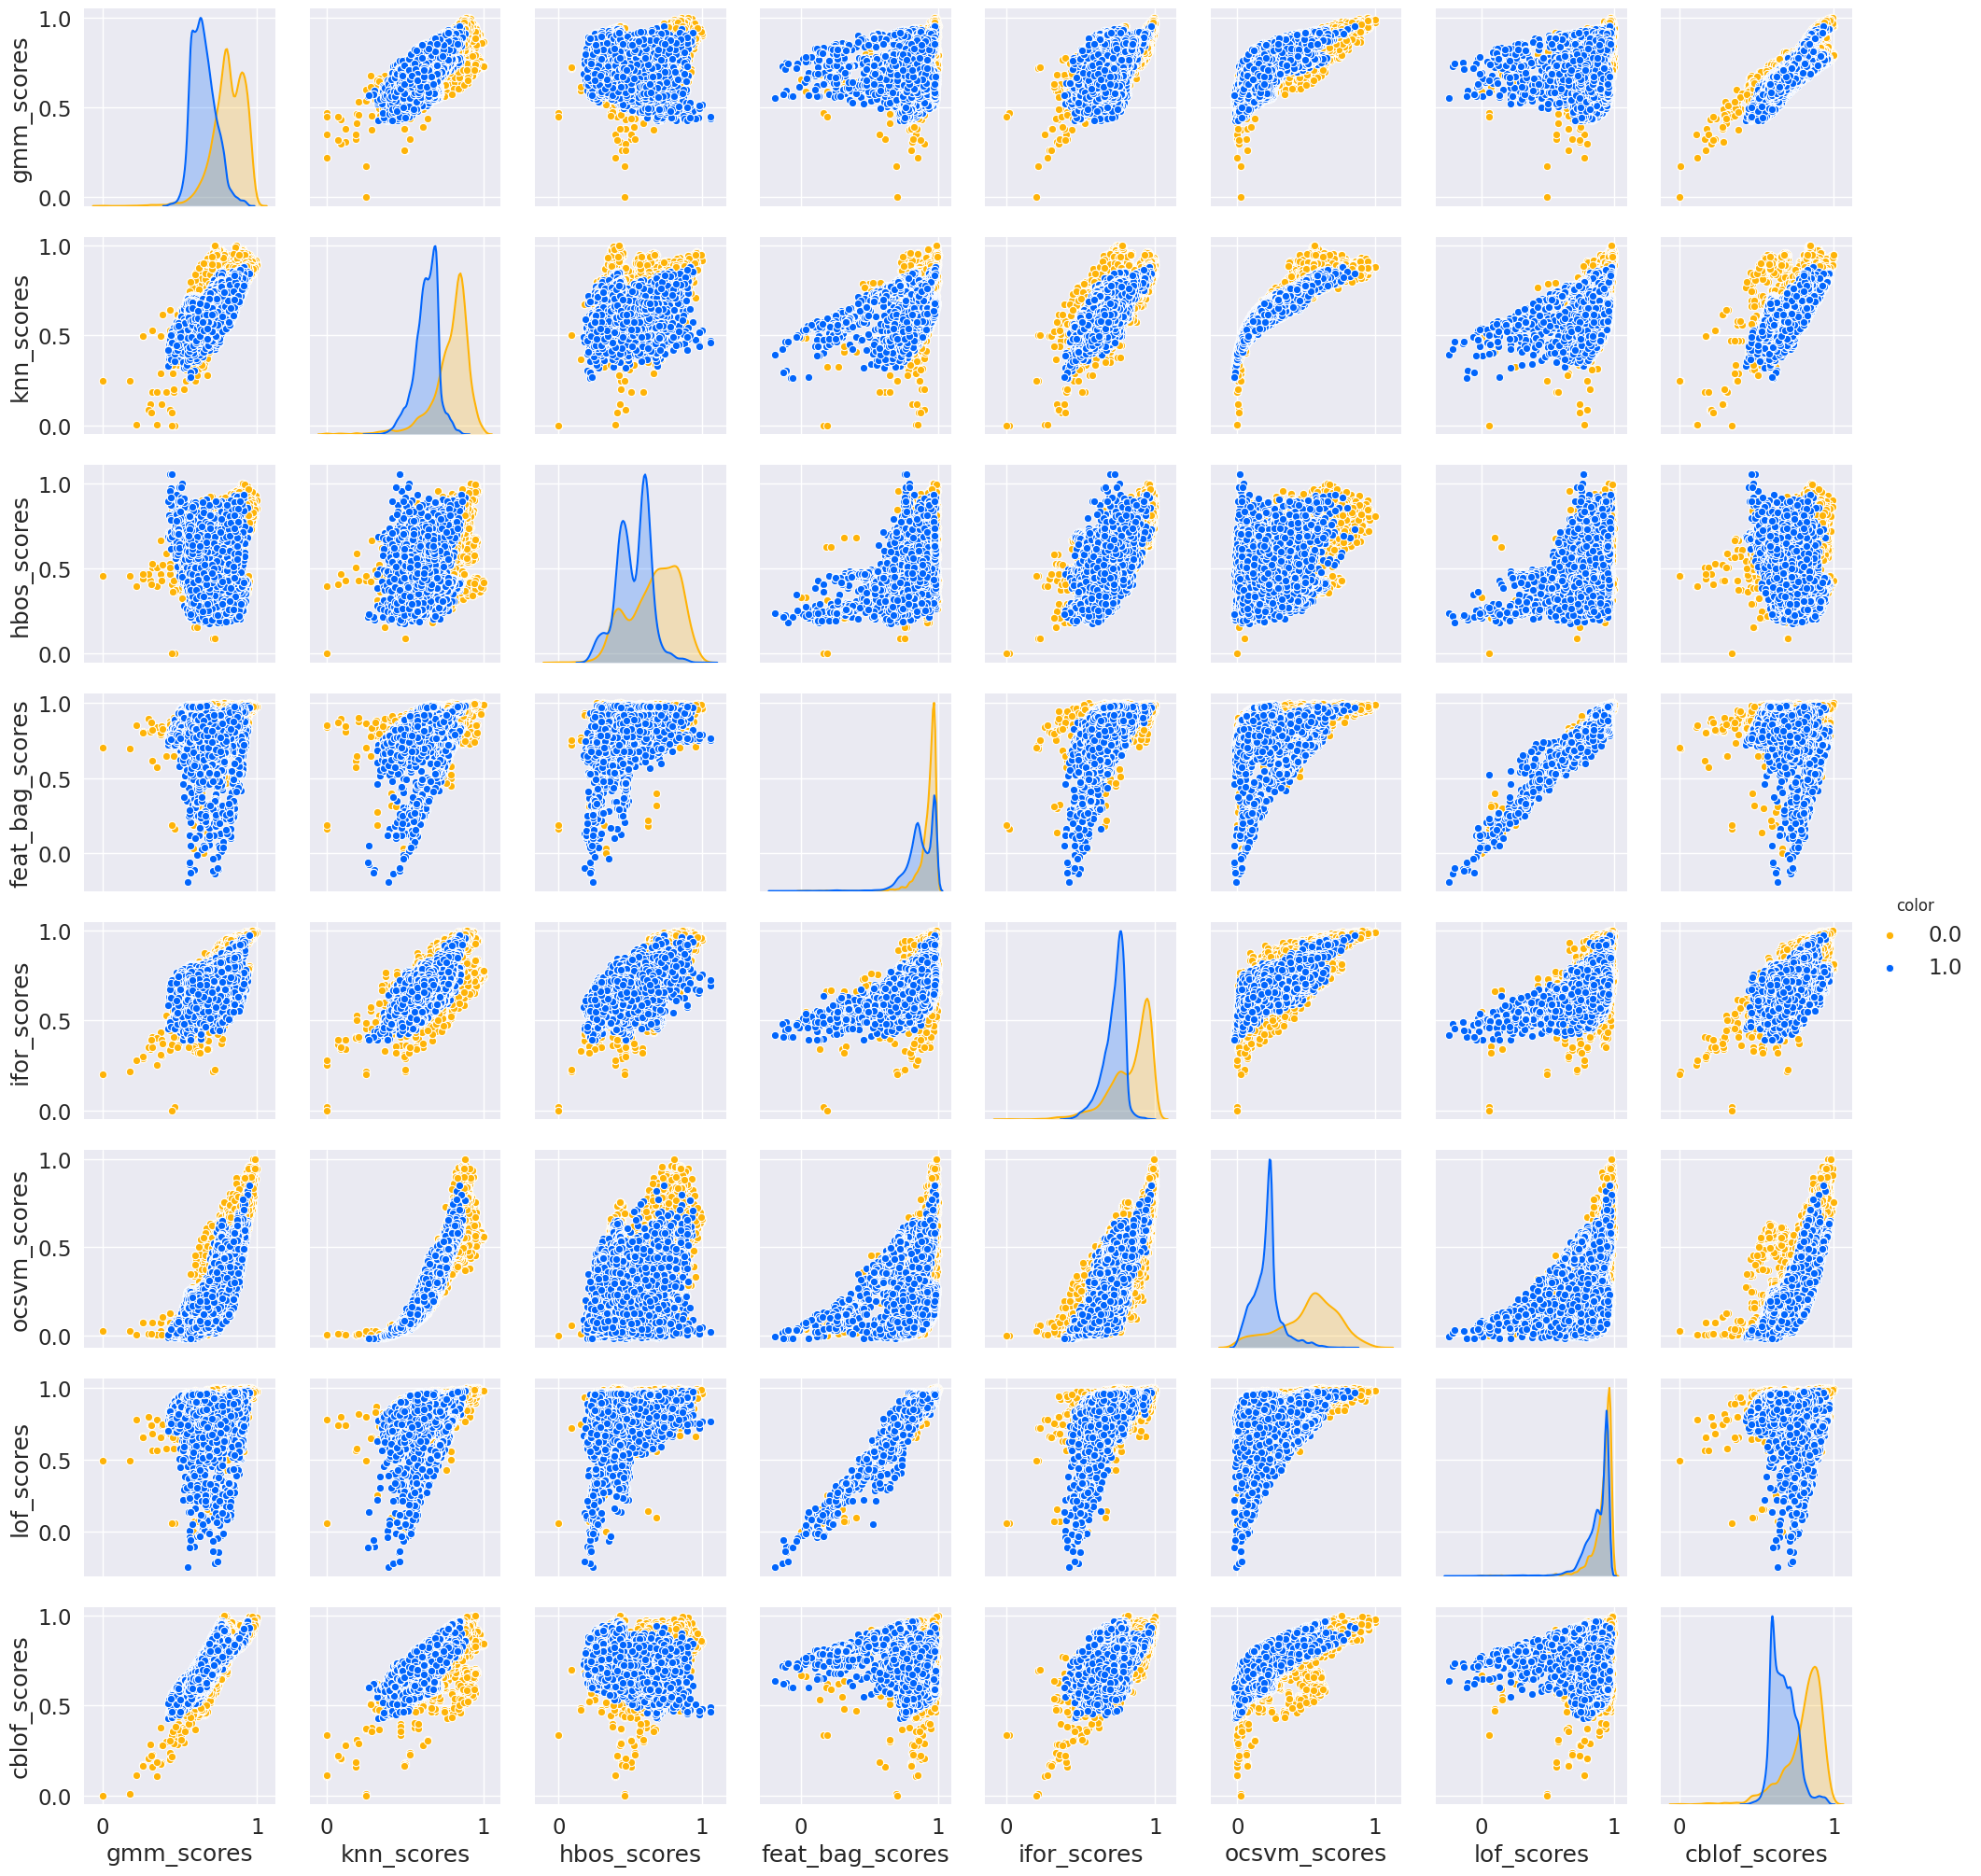

In [857]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
label = pd.concat([pd.DataFrame(np.zeros(df.shape[0])), pd.DataFrame(np.ones(uf.shape[0]))])
sns.set_context("paper", rc={"axes.labelsize":15} )
sns.set_style("whitegrid", {'axes.grid' : False})
sns.axes_style({'xtick.color': '.8'})
sns.set(font_scale = 1.5)
scores_df = pd.DataFrame()
scores_df['gmm_scores'] = gmm1 
scores_df['knn_scores'] = knn1
scores_df['hbos_scores'] = hbos1
scores_df['feat_bag_scores'] = feat_bag1
scores_df['ifor_scores'] = ifor1
scores_df['ocsvm_scores'] = ocsvm1
scores_df['lof_scores'] = lof1
scores_df['cblof_scores'] = cblof1 
scores_df['color'] = label.values.ravel()
color = ['#feb308','#0165fc']
ax = sns.pairplot(scores_df, hue= 'color', palette=color);
sns.despine(left=True, bottom=True)
#ax.savefig('/content/drive/My Drive/cocrystal_design-master/figures/score_corelation.jpg', rasterized=True,  dpi = 600)

In [858]:
# Calculate the normalized scores for the classifiers
def fit_predict(X_train, X_test):
  train_scores=[]
  test_scores = []
  min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
  contamination = 0.05
  for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    if clf_name == 'Gaussiann Mixture Model (GMM)':
      clf.fit(X_train, pd.DataFrame(np.zeros(len(X_train))))
      prob = clf.score_samples(X_train)
      prob = min_max_scaler.fit_transform(np.array(prob).reshape(-1,1))
      prob_t  = clf.score_samples(X_test)
      prob_t = min_max_scaler.transform(np.array(prob_t).reshape(-1,1))
      train_scores.append(prob.ravel())
      test_scores.append(prob_t.ravel())
    else:
      clf.fit(X_train)
      prob=clf.decision_function(X_train) * -1 
      prob = min_max_scaler.fit_transform(np.array(prob).reshape(-1,1))
      prob_t  = clf.decision_function(X_test) * -1
      prob_t = min_max_scaler.transform(np.array(prob_t).reshape(-1,1)) 
      train_scores.append(prob.ravel())
      test_scores.append(prob_t.ravel())
  return train_scores, test_scores
X_train= df.iloc[:, 1:]
X_test = uf
train_scores, test_scores = fit_predict(X_train, X_test)

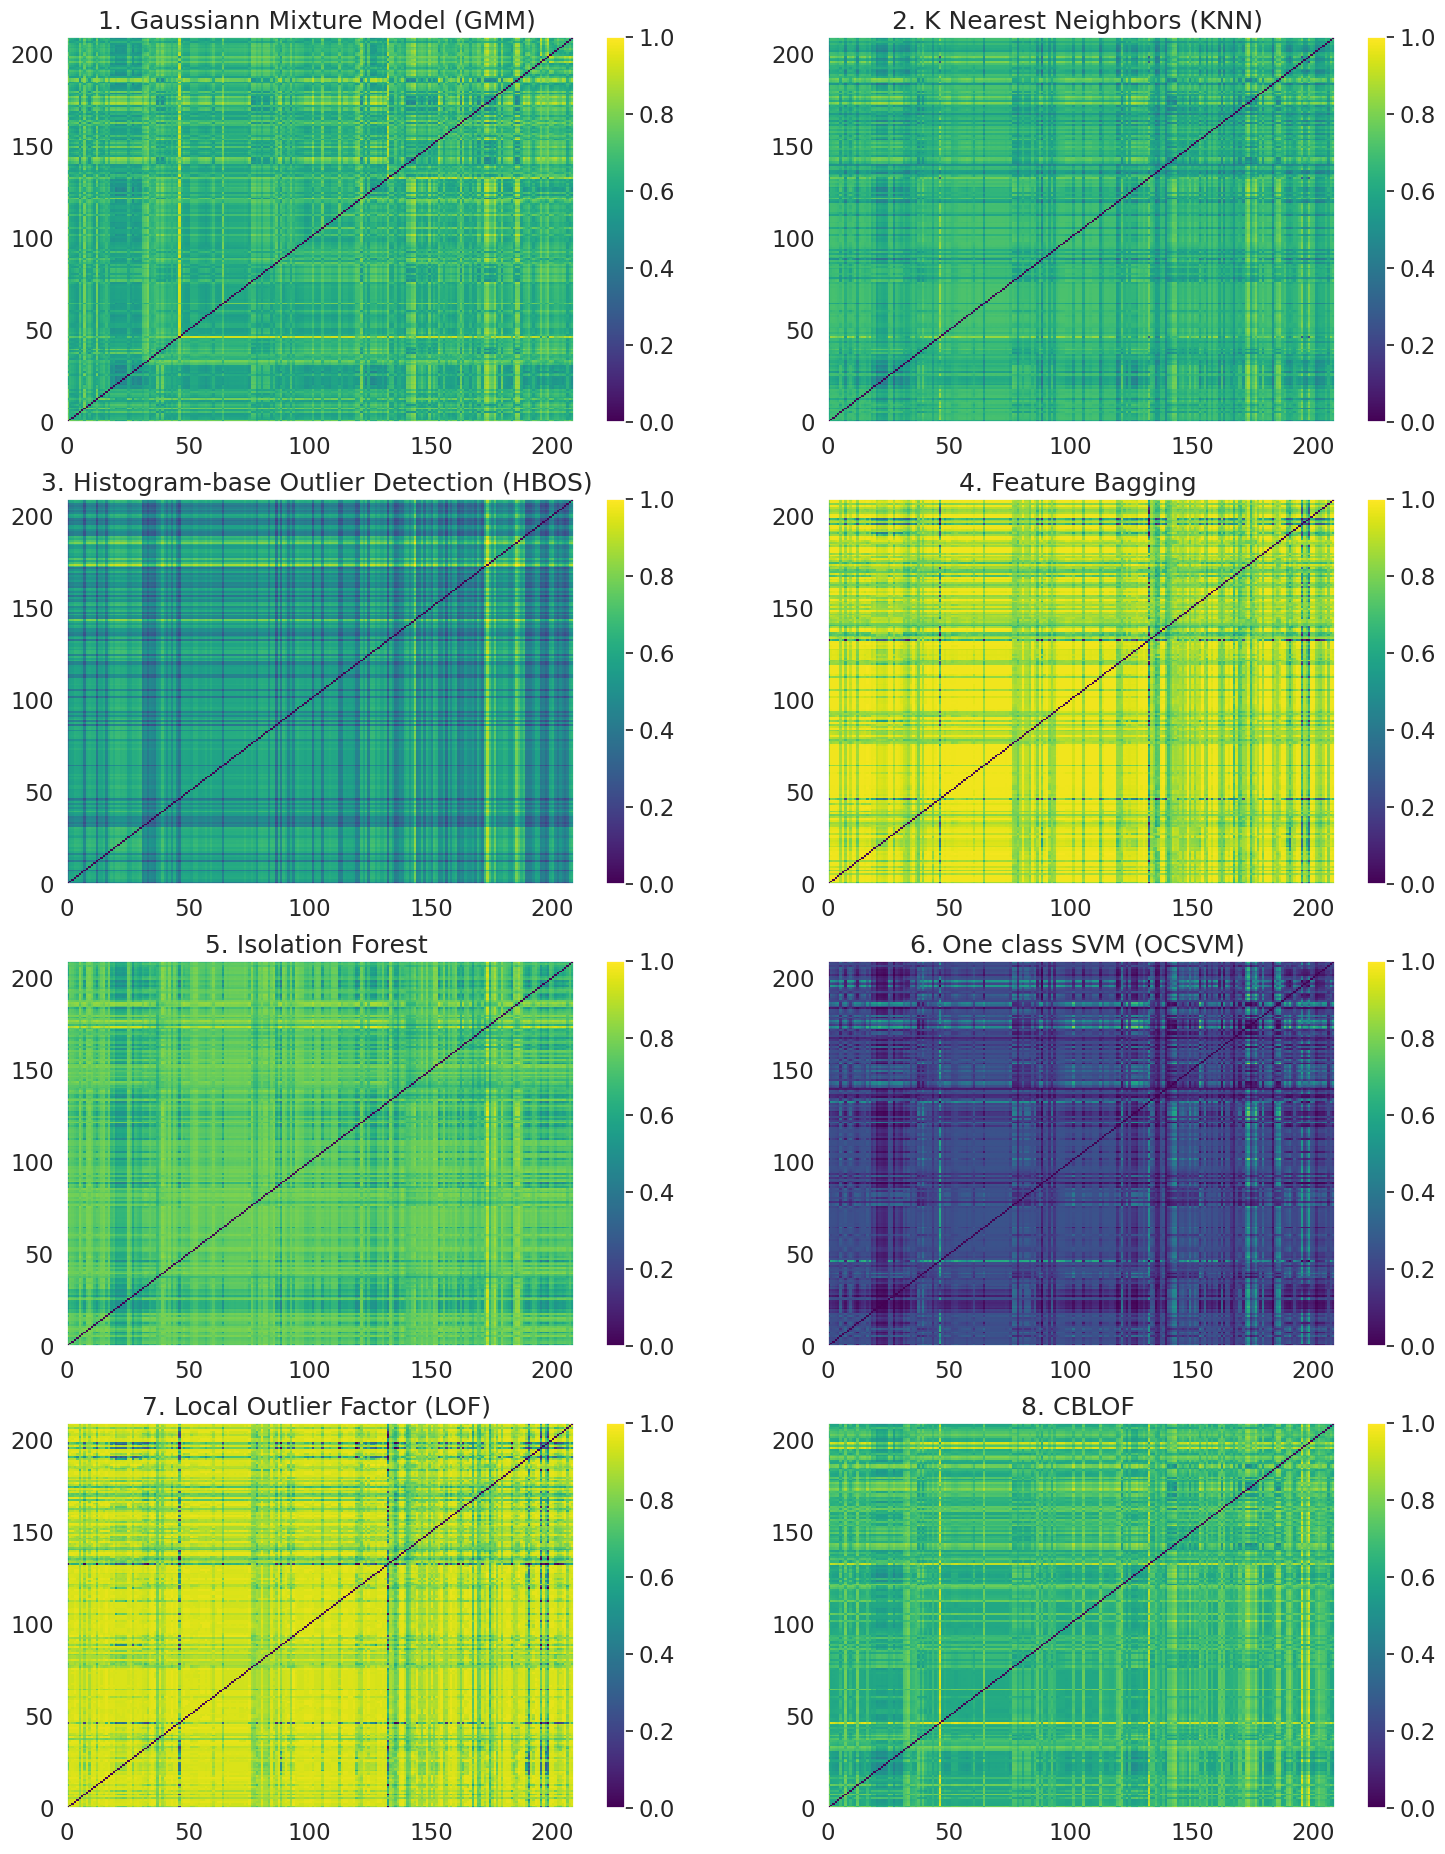

In [859]:
# Generate the heatmaps of all the alrorithms (2 columns x 4 rows)
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"

classifier = {'Gaussiann Mixture Model (GMM)':gmm1[3444:], 'K Nearest Neighbors (KNN)':knn1[3444:], 'Histogram-base Outlier Detection (HBOS)':hbos1[3444:],
        'Feature Bagging':feat_bag1[3444:], 'Isolation Forest':ifor1[3444:], 'One class SVM (OCSVM)':ocsvm1[3444:], 'Local Outlier Factor (LOF)':lof1[3444:] , 'CBLOF':cblof1[3444:]}

plt.figure(figsize=(18, 23))
for i, (clf_name, clf) in enumerate(classifier.items()):
  dist_mat = squareform(clf)
  subplot = plt.subplot(4, 2, i+1)
  N = dist_mat.shape[0]
  cmap = plt.get_cmap('viridis')
  plt.pcolormesh(dist_mat, cmap=cmap)
  plt.colorbar()
  plt.clim(0,1)
  subplot.set_title("%d. %s " % (i + 1, clf_name))

plt.savefig('/content/drive/My Drive/cocrystal_design-master/figures/heatmaps.png', dpi=600)

# Scoring

The final scoring is performed using the ensemble of all the models for more accurate and robust predictions

In [860]:
# Find the average score of all the algorithms (Ensemble scores)

from sklearn import preprocessing
from numpy import percentile
from pyod.models.combination import aom, moa, average, maximization
df=df.fillna(0)
def fit_predict(X_train, X_test):
  train_scores=[]
  test_scores = []
  min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
  contamination = 0.05
  for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    if clf_name == 'Gaussiann Mixture Model (GMM)':
      clf.fit(X_train, pd.DataFrame(np.zeros(len(X_train))))
      prob = clf.score_samples(X_train)
      prob = min_max_scaler.fit_transform(np.array(prob).reshape(-1,1))
      prob_t  = clf.score_samples(X_test)
      prob_t = min_max_scaler.transform(np.array(prob_t).reshape(-1,1))
      c=percentile(prob, 100 * contamination) #pd.DataFrame(proba_t.describe().loc['75%'].astype(float)).iloc[0].values[0]
      train_scores.append(prob.ravel())
      test_scores.append(prob_t.ravel())
    else:
      clf.fit(X_train)
      prob=clf.decision_function(X_train) * -1 
      prob = min_max_scaler.fit_transform(np.array(prob).reshape(-1,1))
      prob_t  = clf.decision_function(X_test) * -1
      prob_t = min_max_scaler.transform(np.array(prob_t).reshape(-1,1)) 
      c=percentile(prob, 100 * contamination) #pd.DataFrame(proba_t.describe().loc['75%'].astype(float)).iloc[0].values[0]
      train_scores.append(prob.ravel())
      test_scores.append(prob_t.ravel())
  return average(np.transpose(train_scores)), average(np.transpose(test_scores)) #train_scores, test_scores  # 

X_train= df.iloc[:, 1:]
X_test = uf
train_scores_av, test_scores_av = fit_predict(X_train, X_test)
lab=pd.DataFrame(train_scores_av, columns=['train_score'])
unlab=pd.DataFrame(test_scores_av, columns=['test_score'])

In [861]:
lab=pd.DataFrame(train_scores_av, columns=['train_score'])
unlab=pd.DataFrame(test_scores_av, columns=['test_score'])

In [862]:
y_scaler = MinMaxScaler(feature_range=(0,1) )
c = train_scores_av
k= test_scores_av

c1 = y_scaler.fit_transform(c.ravel().reshape(-1,1))
k1 =  y_scaler.transform(k.ravel().reshape(-1,1))

In [863]:
# save the scores in a csv

model_scores = pd.concat([pd.DataFrame(gmm1, columns=['gmm1']),pd.DataFrame(knn1, columns=['knn1']), pd.DataFrame(hbos1, columns=['hbos1']), pd.DataFrame(feat_bag1, columns=['feat_bag']),
           pd.DataFrame(ifor1, columns=['ifor1']), pd.DataFrame(ocsvm1, columns=['ocsvm1']), pd.DataFrame(lof1, columns=['lof1']), pd.DataFrame(cblof1, columns=['cblof1'])  ,
           pd.DataFrame(np.concatenate([c1, k1]).ravel(), columns=['ens'])] , axis=1)

model_scores.to_csv('/content/drive/My Drive/cocrystal_design-master/data_test/model_scores_opt.csv')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


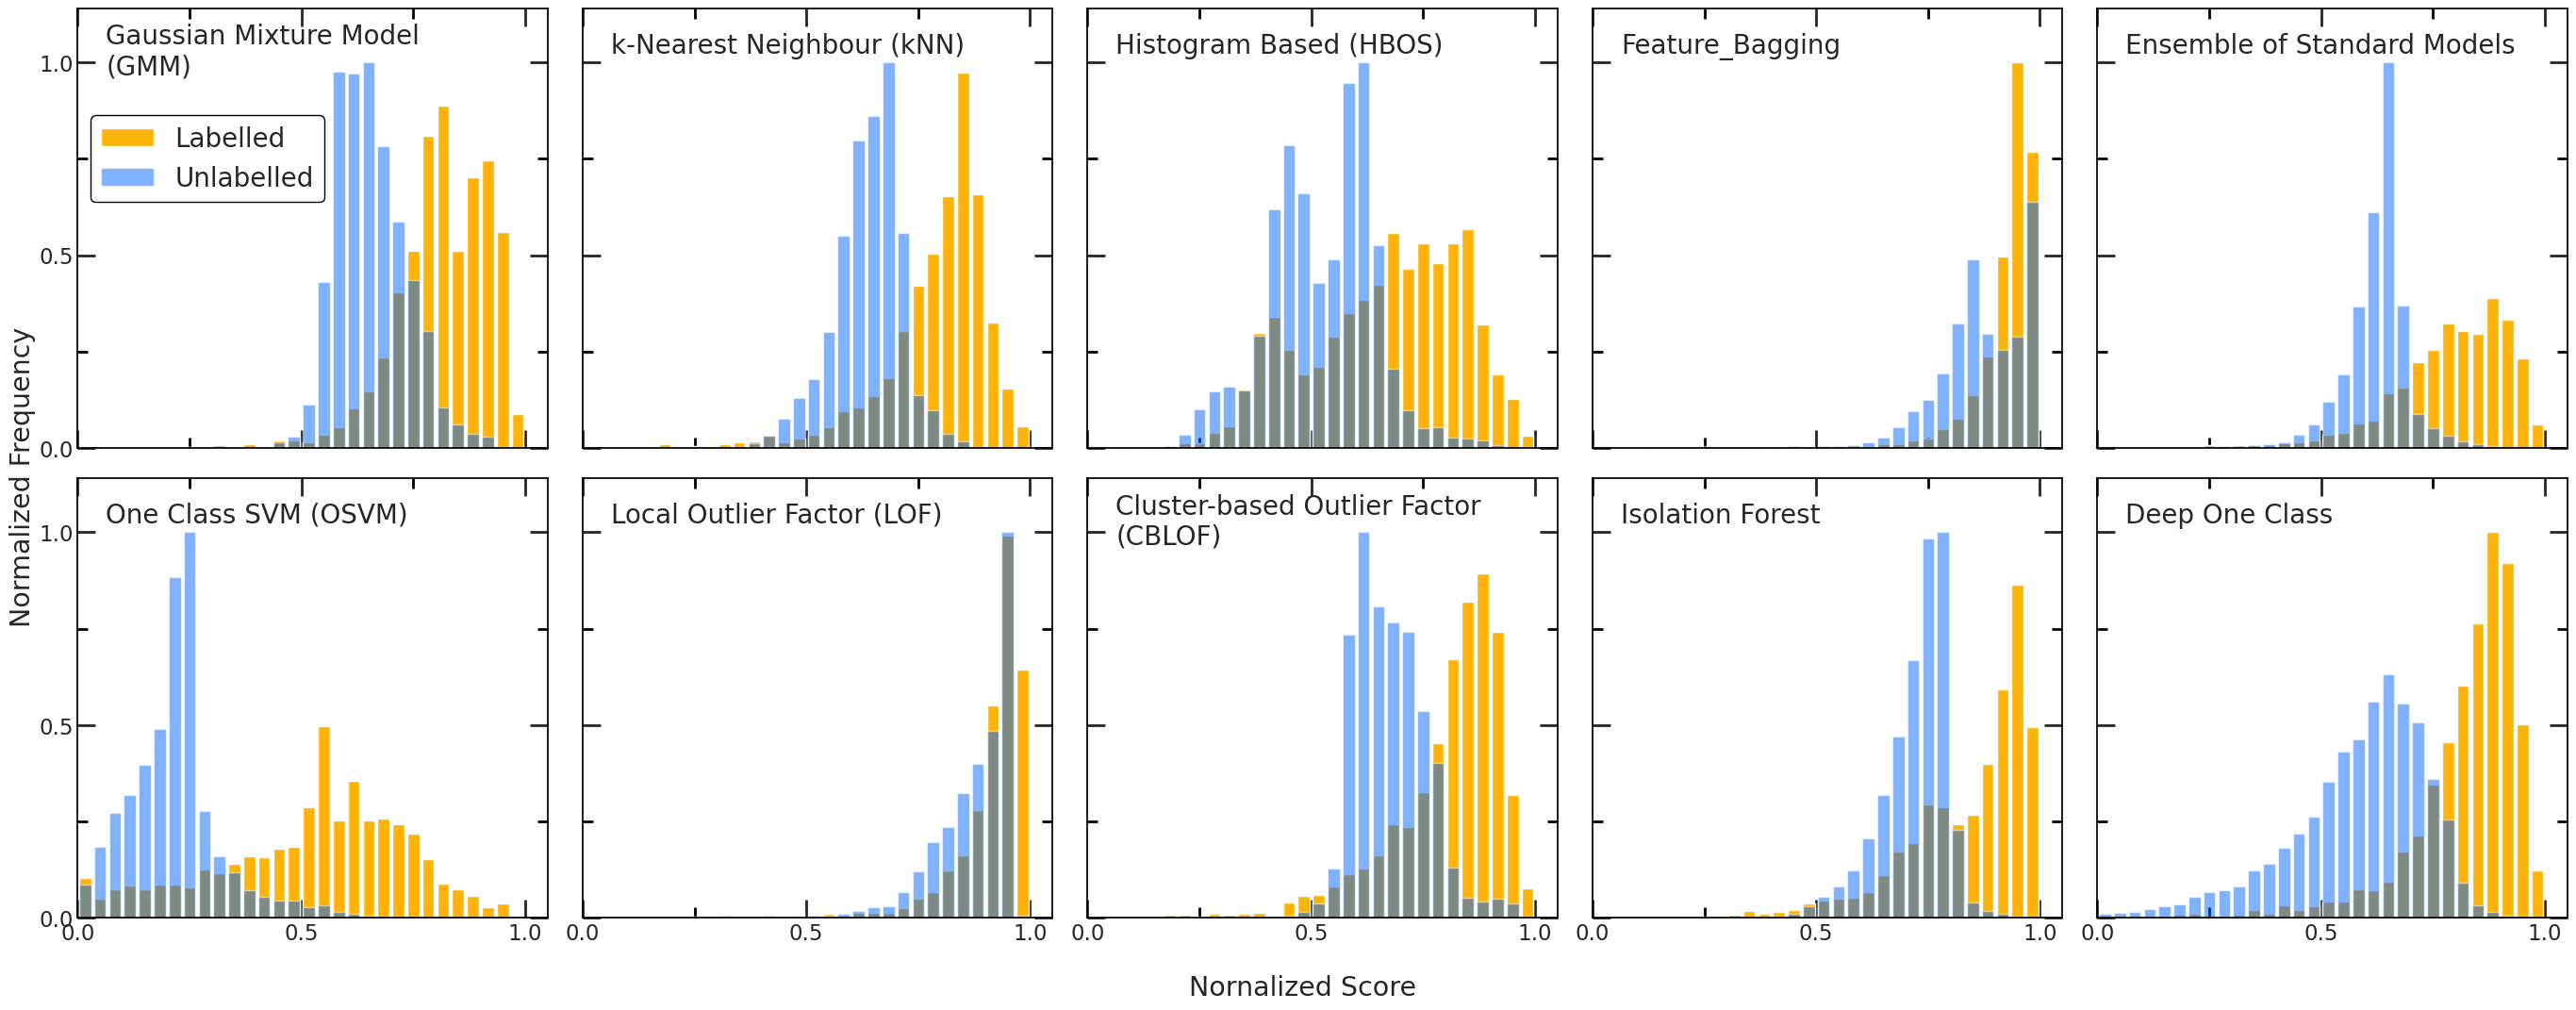

In [864]:
# Construct histograms showing the scores distribution of the labeled/unlabeled data for each algorithm used
import matplotlib.font_manager
from matplotlib import rcParams
import matplotlib.pyplot as plt


fig, axes = plt.subplots(figsize=(26.9, 10), nrows=2, ncols=5,
                         constrained_layout=True, gridspec_kw={'wspace': 0.001, 'hspace': 0.001})

ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = axes.flatten()

rcParams["font.weight"] = "normal"
rcParams["axes.labelweight"] = "normal"
rcParams['font.family'] = 'sans-serif'
rcParams["font.sans-serif"] = "Helvetica"
rcParams["axes.labelsize"] = "xx-large"
rcParams["axes.labelweight"] = "bold"
rcParams["xtick.labelsize"] = "xx-large"
rcParams["ytick.labelsize"] = "xx-large"


major_ticks_x = np.arange(0, 1.1, 0.5)
minor_ticks_x = np.arange(0, 1.1, 0.25)
major_ticks_y = np.arange(0, 1.1, 0.5)
minor_ticks_y = np.arange(0, 1.1, 0.25)

n_bins = 30


def set_ticks(ax):
    ax.tick_params(axis='both', which='both', direction="in", width=2)
    ax.tick_params(axis='both', which='major', direction="in",  length=14)
    ax.tick_params(axis='both', which='minor', length=8,
                   direction="in",  color='black')
    ax.tick_params(axis='both', which='both', bottom=True,
                  top=True, left=True, right=True, direction="in")
    ax.set_xticks(major_ticks_x)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor=True)
    #ax.tick_params(axis='both', top='off', bottom='off', left='off', right='off')
    #ax.xaxis.set_ticks_position('none') 
    #ax.yaxis.set_ticks_position('none') 
    #ax.set_xticks([], minor=True)
    #ax.set_yticks([], minor=True)


def set_spines(ax):
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')


def set_prop(ax):
    ax.axis(aspect='equal')
    ax.set(adjustable='box')  # , aspect='equal')
    ax.set_xlim(0, 1.05)
    ax.set_ylim(0, 1.14)
    ax.grid(False)
    set_spines(ax)
    ax.set_facecolor('xkcd:white')
    ax.axis('on')
    #set_ticks(ax)

def norm_plot(ax, x, y, alpha=1, **kwargs):
    hist, bins = np.histogram(x, **kwargs)
    hist1, _ = np.histogram(y, **kwargs)
    n_max = np.max([hist, hist1])
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    ax.bar(center, hist / n_max, align='center', width = width, alpha=alpha)
    return hist, n_max


def lab_unlab_plot(ax, lab_d, unlab_d, n_bins):
    hist_lab, bins_lab = np.histogram(lab_d, bins=n_bins, density=True, range=(0,1))
    hist_unlab, bins_unlab = np.histogram(unlab_d, bins=n_bins, density=True, range=(0,1))
    n_max = np.max([hist_lab, hist_unlab])
    width_lab = 0.8 * (bins_lab[1] - bins_lab[0])
    width_unlab = 0.8 * (bins_unlab[1] - bins_unlab[0])
    center_lab = (bins_lab[:-1] + bins_lab[1:]) / 2
    center_unlab = (bins_unlab[:-1] + bins_unlab[1:]) / 2
    ax.bar(center_lab, hist_lab / n_max, align='center', width=width_lab, alpha=1, color='#feb308', label = 'Labelled')
    ax.bar(center_unlab, hist_unlab / n_max, align='center', width=width_unlab, alpha=0.5, color='#0165fc', label = 'Unlabelled')


# Gaussian Mixture Model
lab_unlab_plot(ax0, model_scores.gmm1[:3444], model_scores.gmm1[3444:], n_bins)
# ax0.axis(aspect='equal')
ax0.text(0.06, 0.85, 'Gaussian Mixture Model\n(GMM)',
         transform=ax0.transAxes, ha="left", fontsize=20)
#ax0.legend(prop={'size': 20}, loc=(0.02, 0.65), facecolor='white', framealpha=0)
ax0.legend(prop={'size': 20}, loc=(0.028, 0.56), facecolor='white', edgecolor='black', framealpha=1)#,  borderpad=1 ) #shadow=True, fancybox=True, loc=(0.75, -0.15),
ax0.set_xticklabels([])
#ax0.set_yticklabels([])

# knn
n_bins = 30
lab_unlab_plot(ax1, model_scores.knn1[:3444], model_scores.knn1[3444:], n_bins)
ax1.text(0.06, 0.9, 'k-Nearest Neighbour (kNN)',
         transform=ax1.transAxes, ha="left", fontsize=20)
#ax1.legend(prop={'size': 20}, loc=(0.02, 0.7), facecolor='white', framealpha=0)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

# HBOS
lab_unlab_plot(ax2, model_scores.hbos1[:3444], model_scores.hbos1[3444:], n_bins)
ax2.text(0.06, 0.9, 'Histogram Based (HBOS)',
         transform=ax2.transAxes, ha="left", fontsize=20)
#ax2.legend(prop={'size': 20}, loc=(0.02, 0.7), facecolor='white', framealpha=0)
ax2.set_xticklabels([])
ax2.set_yticklabels([])

# Feature Bagging
lab_unlab_plot(ax3, model_scores.feat_bag[:3444], model_scores.feat_bag[3444:], n_bins)
ax3.text(0.06, 0.9, 'Feature_Bagging',
         transform=ax3.transAxes, ha="left", fontsize=20)
#ax3.legend(prop={'size': 20}, loc=(0.02, 0.7), facecolor='white', framealpha=0)
ax3.set_xticklabels([])
ax3.set_yticklabels([])

# Isolation Forest
lab_unlab_plot(ax8, model_scores.ifor1[:3444], model_scores.ifor1[3444:], n_bins)
ax8.text(0.06, 0.9, 'Isolation Forest',
         transform=ax8.transAxes, ha="left", fontsize=20)
#ax8.legend(prop={'size': 20}, loc=(0.02, 0.7), facecolor='white', framealpha=0)
#ax8.set_xticklabels([])
ax8.set_yticklabels([])

# OCSVM
lab_unlab_plot(ax5, model_scores.ocsvm1[:3444], model_scores.ocsvm1[3444:], n_bins)
ax5.text(0.06, 0.9, 'One Class SVM (OSVM)',
         transform=ax5.transAxes, ha="left", fontsize=20)
#ax5.legend(prop={'size': 20}, loc=(0.02, 0.7), facecolor='white', framealpha=0)
#ax5.set_xticklabels([])
#ax5.set_yticklabels([])

# LOF
lab_unlab_plot(ax6, model_scores.lof1[:3444], model_scores.lof1[3444:], n_bins)
ax6.text(0.06, 0.9, 'Local Outlier Factor (LOF)',
         transform=ax6.transAxes, ha="left", fontsize=20)
#ax6.legend(prop={'size': 20}, loc=(0.02, 0.65),
 #          facecolor='white', framealpha=0)
#ax6.set_xticklabels([])
ax6.set_yticklabels([])


# CBLOF
lab_unlab_plot(ax7, model_scores.cblof1[:3444], model_scores.cblof1[3444:], n_bins)
ax7.text(0.06, 0.85, 'Cluster-based Outlier Factor\n(CBLOF)',
         transform=ax7.transAxes, ha="left", fontsize=20)
#ax7.legend(prop={'size': 20}, loc=(0.02, 0.65),
 #          facecolor='white', framealpha=0)
#ax7.set_xticklabels([])
ax7.set_yticklabels([])

# DeepSVDD
lab_unlab_plot(ax9, deep_scores.score[:1722], deep_scores.score[1722:], n_bins)
ax9.text(0.06, 0.9, 'Deep One Class',
         transform=ax9.transAxes, ha="left", fontsize=20)
#ax9.legend(prop={'size': 20}, loc=(0.02, 0.7), facecolor='white', framealpha=0)
#ax9.set_xticklabels([])
ax9.set_yticklabels([])

# Ensemble
lab_unlab_plot(ax4, model_scores.ens[:3444], model_scores.ens[3444:], n_bins)
ax4.text(0.06, 0.9, 'Ensemble of Standard Models', 
        transform=ax4.transAxes, ha="left", fontsize=20)
#ax4.legend(prop={'size': 20}, loc=(0.02, 0.7), facecolor='white', framealpha=0)
ax4.set_xticklabels([])
ax4.set_yticklabels([])

for ax in axes.flatten():
  set_prop(ax)
  set_ticks(ax)

fig.tight_layout()


fig.text(0.5, -0.05, 'Nornalized Score', ha='center',fontsize=20.5 )
fig.text(-0.01, 0.5, 'Normalized Frequency', va='center', rotation='vertical', fontsize=20.5)
#plt.savefig('/content/drive/My Drive/cocrystal_design-master/figures/figure2_new.png', rasterized=True,  bbox_inches="tight", dpi=600)

plt.show()


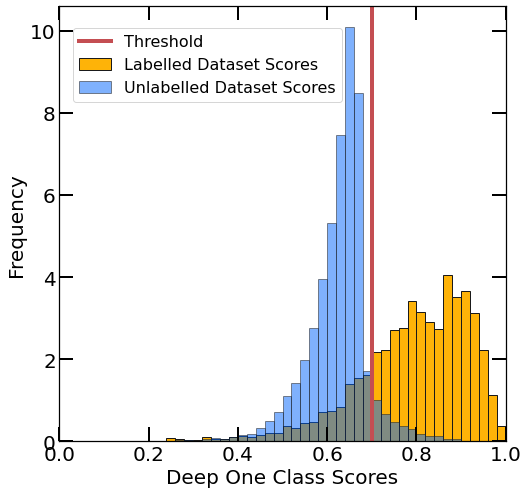

In [845]:
%matplotlib inline
from matplotlib.pyplot import figure

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

_, bins , _ = plt.hist(c1, bins=50, ec='k', histtype='bar', density=True, alpha=1, color='#feb308', label='Labelled Dataset Scores')

_= plt.hist(k1, bins=bins,density=True, ec='k',alpha=0.5, color='#0165fc', label='Unlabelled Dataset Scores')
#_= plt.hist(val.train_score, bins=bins,density=True, ec='k',alpha=0.5, color='red', label='Unlabelled Dataset Scores')
_ = plt.axvline(x=0.7, label='Threshold', c='r', linewidth=4)

plt.grid(False)
plt.xlim(0, 1.0)
plt.xlabel('Deep One Class Scores', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
#major_ticks_x = np.arange(0, 1.001, 0.2)
#minor_ticks_x = np.arange(0,1.001, 0.1)
#major_ticks_y = np.arange(0, 6, 2)
#minor_ticks_y = np.arange(0, 6, 1)
ax.tick_params(axis = 'both', which='both', width=2)
ax.tick_params(axis = 'both', which='major', length=14)
ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction="in")
#ax.set_xticks(major_ticks_x)
#ax.set_xticks(minor_ticks_x, minor=True)
#ax.set_yticks(major_ticks_y)
#ax.set_yticks(minor_ticks_y, minor=True)

plt.legend(prop={'size': 16}, loc=[0.03, 0.78])
plt.savefig('/content/drive/My Drive/cocrystal_design-master/figures/ensemble_scores_ histogram.png' ,rasterized=True,  bbox_inches="tight", dpi=600)
plt.show()

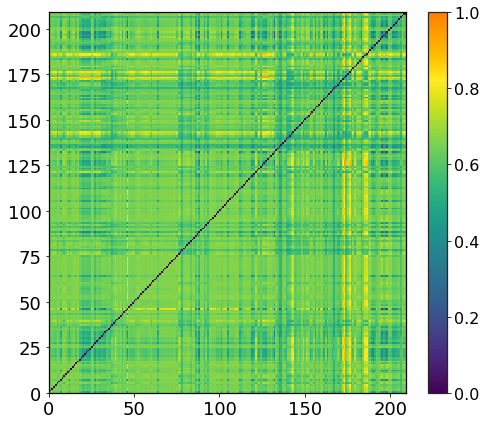

In [846]:
# Scores distribuition histogram
fig = plt.figure(figsize=(8,7))

ax = fig.add_subplot(111)
dist_mat = squareform(k1.ravel())
N = dist_mat.shape[0]

top = cm.get_cmap('viridis', 512)
bottom = cm.get_cmap('Wistia', 512)

newcolors = np.vstack((top(np.linspace(0, 1, 812)),
                       bottom(np.linspace(0.2, 1, 180))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

plt.pcolormesh(dist_mat, cmap=  newcmp)

cbar = plt.colorbar(ax=ax)
plt.clim(0,1) 
cbar.ax.tick_params(labelsize=16) 
plt.xlim([0,N])
plt.ylim([0,N])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.xaxis.label.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
plt.savefig('/content/drive/My Drive/cocrystal_design-master/figures/ensemble_scores_ heatmap.png' ,rasterized=True,  bbox_inches="tight", dpi=600)
plt.show()

# Visualization of the predictions

In [879]:
uf_final = pd.DataFrame(uf_final.values, columns=df.columns.values)

In [880]:
top=pd.concat([uf_final['Identifier'], pd.DataFrame(k, columns=['test_score'] )], axis=1)  #k1
top

Identifier  test_score
0          comb1    0.669713
1          comb2    0.666992
2          comb3    0.659464
3          comb4    0.642284
4          comb5    0.670850
...          ...         ...
21731  comb21732    0.665635
21732  comb21733    0.635081
21733  comb21734    0.617373
21734  comb21735    0.620026
21735  comb21736    0.667584

[21736 rows x 2 columns]

In [881]:
c=pd.DataFrame(top.describe().loc['75%'].astype(float)).iloc[0].values[0]
proba_ = top.sort_values(by = ['test_score'], ascending=True)
b = top[top['test_score'] > c]
b=b.sort_values(by = ['test_score'], ascending=False)
print('Threshold:', c)
len(b)

Threshold: 0.6761701259592725


5434

In [882]:
solvents = ['C1Cc2ccccc12', 'Brc1ccccc1', 'c1ccc2cnncc2c1', 'Cc1ccccc1', 'Cc1ccccc1C', 'Clc1ccccc1', 'Clc1ccccc1', 'Ic1ccccc1']
solvates=[]
for x in b['Identifier']:
  if dict1[x][0] in solvents:
    solvates.append(x)
        
  if dict1[x][1] in solvents:
      solvates.append(x)

solvates = Remove(solvates)
len(solvates)
predictions1 = b[~b.Identifier.isin(solvates)]

Number of combinations: 97


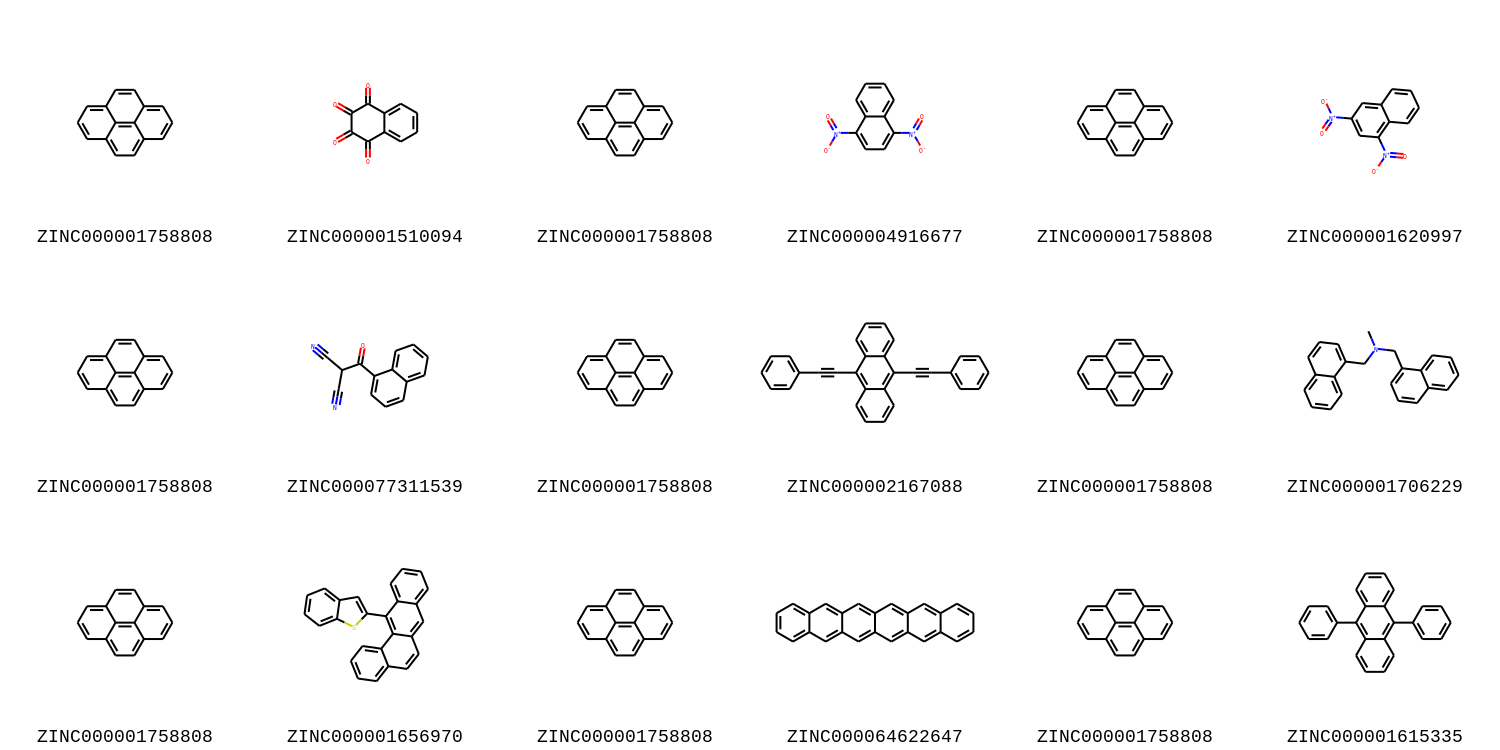

In [883]:
# Show all the combinatios with  9,10-Anthracenedicarbonitrile 

anthdini=[]
for x in predictions1.Identifier:
  if dict1[x][0] == 'c1cc2ccc3cccc4ccc(c1)c2c34':
    anthdini.append(x)        
  if dict1[x][1] == 'c1cc2ccc3cccc4ccc(c1)c2c34':
    anthdini.append(x)

anthdini= Remove(anthdini)    
print('Number of combinations:',len(anthdini))
listaki=[]
score=[]


for i in anthdini[:9]:                      # select the number of the predictions you want to see
  score.append(b[b.Identifier ==i].test_score)
  listaki.append(dict1[i])
   
ar=np.array(listaki)
ar=ar.tolist()

import itertools
Draw.IPythonConsole.drawOptions.legendFontSize = 18
Draw.IPythonConsole.drawOptions.atomLabelFontSize = 12
Draw.IPythonConsole.drawOptions.atomLabelMinFontSize = 70

IPythonConsole.molSize = (500,500)
merged = list(itertools.chain(*ar))
subms = [Chem.MolFromSmiles(x) for x in merged]
img=Draw.MolsToGridImage(subms,molsPerRow=6,subImgSize=(250,250),legends=[zinc_dict[x] for x in merged])
img#.save('/content/drive/My Drive/cocrystal_design-master/figures/ensemble_pyrene.png', "PNG")

In [884]:
score

[1673    0.767369
 Name: test_score, dtype: float64, 1822    0.734004
 Name: test_score, dtype: float64, 1825    0.732795
 Name: test_score, dtype: float64, 1759    0.705343
 Name: test_score, dtype: float64, 1815    0.70394
 Name: test_score, dtype: float64, 1714    0.699704
 Name: test_score, dtype: float64, 1827    0.697548
 Name: test_score, dtype: float64, 1755    0.69623
 Name: test_score, dtype: float64, 1808    0.694105
 Name: test_score, dtype: float64]

In [885]:
c=pd.DataFrame(top.describe().loc['75%'].astype(float)).iloc[0].values[0]
proba_ = top.sort_values(by = ['test_score'], ascending=True)
b = top[top['test_score'] > c]
b=b.sort_values(by = ['test_score'], ascending=False)
predictions = list(b['Identifier'])

In [886]:
listaki=[]
for i in predictions[:]: #both:
  listaki.append(dict1[i])

In [895]:
# Count molecules after removing solvents
solvents = ['C1Cc2ccccc12', 'Brc1ccccc1', 'c1ccc2cnncc2c1', 'Cc1ccccc1', 'Cc1ccccc1C', 'Clc1ccccc1', 'Ic1ccccc1', ]
data1 = pd.DataFrame(listaki)[:].iloc[:, 0]
data1 = [x for x in data1.values if x not in solvents]
data1= pd.DataFrame(data1, columns=['a'])
dat1 = pd.DataFrame(data1['a'].value_counts())[:10]

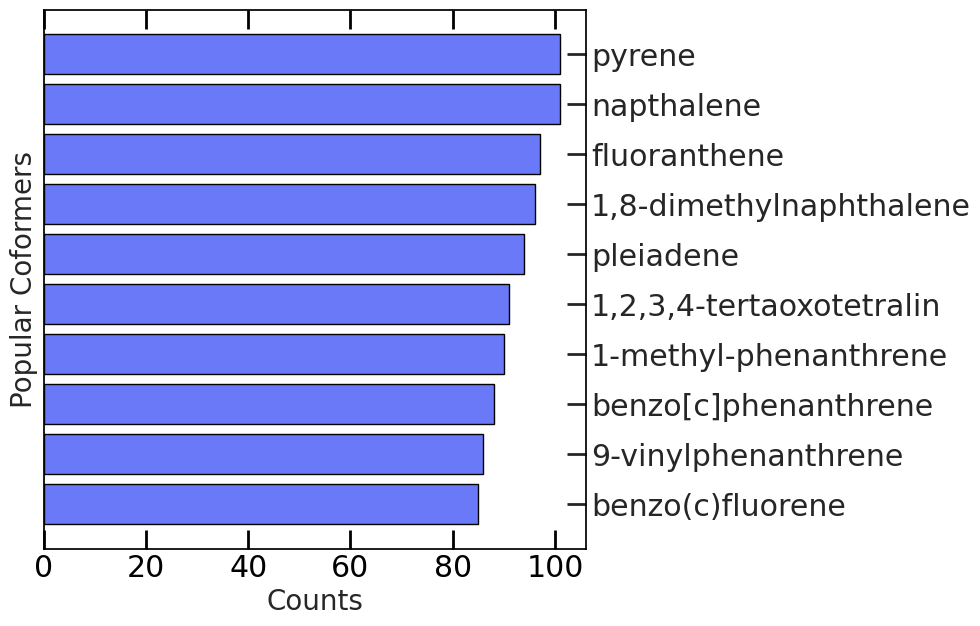

In [893]:
import matplotlib.font_manager
from matplotlib import rcParams

rcParams["font.weight"] = "normal"
rcParams["axes.labelweight"] = "normal"
rcParams['font.family'] = 'sans-serif'
rcParams["font.sans-serif"] = "Helvetica"
rcParams["axes.labelsize"] = "xx-large"
rcParams["axes.labelweight"]= "bold"
rcParams["xtick.labelsize"] = "large"
rcParams["ytick.labelsize"] = "large"
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid']=False
rcParams['patch.edgecolor'] = 'black'

fig, ax = plt.subplots(figsize=(7,7))
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.tick_params(axis = 'both', which='both', width=2)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis = 'both', which='major', length=14)
ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')



x = ['pyrene', 'napthalene', 'fluoranthene', '1,8-dimethylnaphthalene', 'pleiadene', '1,2,3,4-tertaoxotetralin', '1-methyl-phenanthrene',  'benzo[c]phenanthrene', 
        '9-vinylphenanthrene', 'benzo(c)fluorene', ]

energy = dat1.a
x_pos = [i for i, _ in enumerate(x)]

idx = np.asarray([i for i in range(len(x))])                 
#ax.set_yticks(idx)
ax.yaxis.set_label_position("left")
ax.yaxis.tick_right()

plt.barh(x_pos, energy, color='#6a79f7')
plt.gca().invert_yaxis()
plt.ylabel("Popular Coformers",fontsize=20, fontweight='normal')
plt.xlabel("Counts" ,fontsize=20,  fontweight='normal')

plt.yticks(x_pos, x)
plt.savefig('/content/drive/My Drive/cocrystal_design-master/figures/ens_pop.png', rasterized=True,  bbox_inches="tight", dpi=600)
plt.show()

# Scatterplot

In [898]:
ens = np.concatenate([lab.iloc[:1722, :].train_score, unlab.test_score])      
pd.DataFrame(ens, columns=['scores']).to_csv('/content/drive/My Drive/cocrystal_design-master/data_test/ensemble_scores_opt.csv', index=False) 
deep_scores = pd.read_csv('/content/drive/My Drive/cocrystal_design-master/data/deep_scores_60_epochs.csv')
           

In [899]:
from scipy import stats
deep=deep_scores.score.values
data = pd.concat([pd.DataFrame(deep, columns=['deep']), pd.DataFrame(ens, columns=['ens'])], axis=1)
data=data[data.deep>0]
data1 = data[data.deep>0.7]
x= data1.deep
slope, intercept, r_value, p_value, std_err = stats.linregress( data1['deep'] ,data1['ens'])
line = slope*data1.deep+intercept
tzaki = pd.concat([pd.DataFrame(data1.deep, columns=['deep']), pd.DataFrame(line.values, columns=['line'])], axis=1)

In [900]:
data = pd.concat([pd.DataFrame(deep, columns=['deep']), pd.DataFrame(ens, columns=['ens'])], axis=1)
data=data[data.deep>0]
data1 = data[data.deep>0.70]
x= data1.deep
slope, intercept, r_value, p_value, std_err = stats.linregress( data1['deep'] ,data1['ens'])
line = slope*data.deep+intercept
tzaki = pd.concat([pd.DataFrame(data.deep.values, columns=['deep']), pd.DataFrame(line.values, columns=['line'])], axis=1)

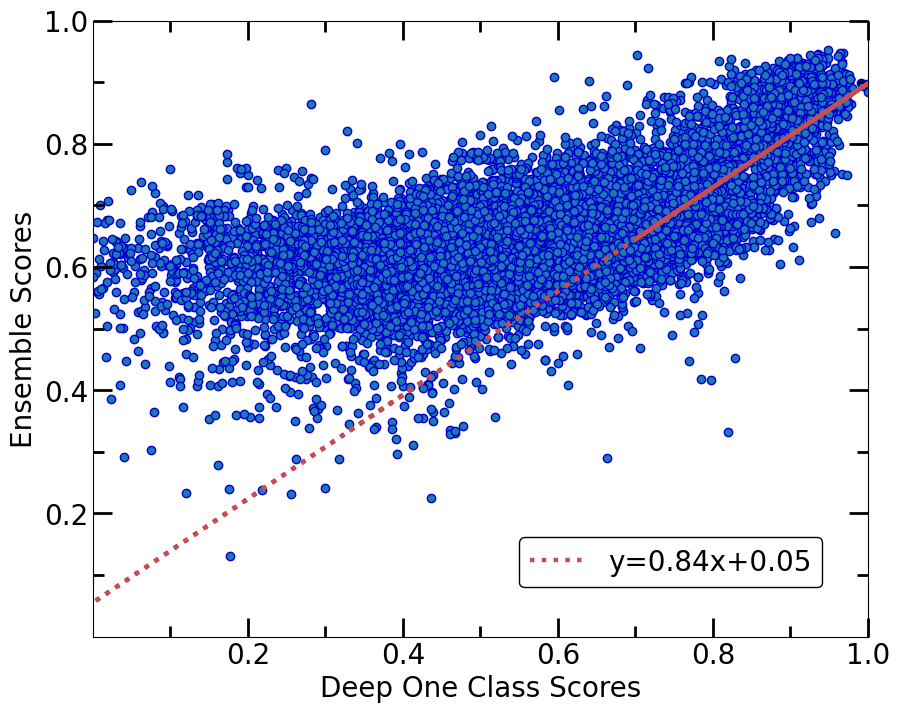

In [901]:
from matplotlib import rc
import seaborn as sns
from matplotlib import rcParams
import matplotlib.font_manager
#plt.rcParams["font.weight"] = "light"
#plt.rcParams["axes.labelweight"] = "light"
plt.rcParams['axes.facecolor'] = 'white'


plt.style.use('default')
import matplotlib.font_manager
rcParams["font.weight"] = "normal"
rcParams["axes.labelweight"] = "normal"
rcParams['font.family'] = 'sans-serif'
rcParams["font.sans-serif"] = "Helvetica"
rcParams["axes.labelsize"] = "xx-large"
rcParams["axes.labelweight"]= "normal"
rcParams["xtick.labelsize"] = "xx-large"
rcParams["ytick.labelsize"] = "xx-large"
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid']=False

#fig = plt.figure(figsize=(10,8))
fig, ax = plt.subplots(figsize=(10,8))
rcParams["axes.edgecolor"] = "0.15"
rcParams["axes.linewidth"]  = 1.25

plt.scatter(data.deep, data.ens, edgecolors='#0000CC')
slope, intercept, r_value, p_value, std_err = stats.linregress( data.deep , data.ens)
line = slope*deep+intercept
#plt.plot(deep, line, 'r', linewidth=3.0, label='y={:.2f}x+{:.2f}'.format(slope,intercept))

#plt.legend(loc='lower right')

plt.grid(False)

plt.xlim(0, 1.0)
plt.ylim(0, 1.0)
plt.xlabel('Deep One Class Scores', fontsize=20)
plt.ylabel('Ensemble Scores', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
# this is an inset axes over the main axes
#a = plt.axes([.6, .15, .28, .28], facecolor='white')
#sns.regplot(x="deep", y="ens", data=data1, color='b',
 #line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept), 'color': 'red'})

#plt.scatter(data1.deep, data1.ens, edgecolors='#0000CC')
x= data1.deep
slope, intercept, r_value, p_value, std_err = stats.linregress( data1['deep'] ,data1['ens'])
line = slope*data.deep+intercept
#plt.plot(data.deep, line,  'r', linestyle='-', linewidth=3.0, dashes=(5, 2), label='y1={:.2f}x+{:.2f}'.format(slope,intercept))
plt.plot(tzaki[tzaki.deep > 0.7].deep,tzaki[tzaki.deep > 0.7].line, 'r-',  linewidth=3.2)
plt.plot(tzaki[tzaki.deep < 0.7].deep,tzaki[tzaki.deep < 0.7].line, 'r:',  linewidth=3.2, label='y={:.2f}x+{:.2f}'.format(slope,intercept))


slope, intercept, r_value, p_value, std_err = stats.linregress( data.deep , data.ens)
line = slope*deep+intercept

#plt.plot(deep, line, 'r', linewidth=3.0, label='y1={:.2f}x+{:.2f}'.format(slope,intercept))

major_ticks_x = np.arange(0, 1.001, 0.2)
minor_ticks_x = np.arange(0, 1.001, 0.1)
major_ticks_y = np.arange(0, 1.001, 0.2)
minor_ticks_y = np.arange(0, 1.001, 0.1)
ax.tick_params(axis = 'both', which='both', width=2)
ax.tick_params(axis = 'both', which='major', length=14)
ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction="in")
ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)
ax.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax.yaxis.get_major_ticks()[0].draw = lambda *args:None
plt.legend(prop={'size': 20}, loc=(0.55, 0.08), facecolor='white', edgecolor='black', framealpha=1 )
#plt.savefig('/content/drive/My Drive/cocrystal_design-master/figures/scatter8_7.png', dpi=600)